In [1]:
import numpy as np
from os.path import join,isfile
from os import listdir
from tqdm import tqdm
import json
import pickle
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr,spearmanr,percentileofscore
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from transformers import BertTokenizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/nlp/scr/cpenelto/miniconda3/envs/candice-base/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
filter_labels = {'Evans Early American Imprints','HeinOnline','National Archives Founders Online'}
layer = 12
file_header  = 'cofea_histbert_vectors_' # "cofea_sampled_vectors_" 
embedding_dir = join('data','embeddings')
embedding_files = [f for f in listdir(embedding_dir) if isfile(join(embedding_dir, f))
                  and file_header in f]
indir = join('data','preprocessed')
outdir = join('data','images')
special_terms_file = join('data','interest_terms.txt')
constitution_terms_file = join('data','constitution_words.txt') # did not prune the names from the original list
# pulling up cleaned list to filter out unwanted terms
sample_index_file = join(indir,'sample_target_index.dict')
cofea_index_file = join(indir,'target_word_index.dict') # the target word contains the bigrams we need
data_file = join(indir, 'cofea.jsonlist')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
silhouette_source_file = join(indir,file_header+'sillhouette_scores_subset_variation.dict')
silhouette_kmeans_file = join(indir,file_header+'silhouette_scores_over_all_variation.dict')

In [3]:
# load needed files

# load special terms of interest
with open(special_terms_file, 'r',encoding = 'utf-8') as f:
    special_terms = f.read().splitlines()
    
# they were indexed and saved in their tokenized form 
special_terms = [tokenizer.tokenize(x) for x in special_terms]

special_terms_cleaned = []
for x in special_terms:
    # rejoin into concatenated words
    rejoined_pieces = []
    for p_i, piece in enumerate(x):
        if p_i == 0:
            rejoined_pieces.append(piece)
        elif piece.startswith('##'):
            rejoined_pieces[-1] += piece
        else:
            rejoined_pieces.append(piece)
    special_terms_cleaned.append(' '.join(rejoined_pieces))
special_terms_cleaned = set(special_terms_cleaned)

# full cofea index for frequency
with open(cofea_index_file,'rb') as f:
    cofea_index = pickle.load(f)
    
# full sample index to get the dates of the samples
with open(sample_index_file,'rb') as f:
    sample_index = pickle.load(f)
    
# cofea file data for dates, source, etc
with open(data_file) as f:
     cofea_data = f.readlines()
    
# silhouette scores for source clusters
with open(silhouette_source_file,'rb') as f:
    silhouette_source_scores = pickle.load(f)
    
# silhouette scores for kmeans clusters
with open(silhouette_kmeans_file,'rb') as f:
    silhouette_kmeans_scores = pickle.load(f)

In [4]:
# clearing out names
# load constitution
with open(constitution_terms_file, 'r',encoding = 'utf-8') as f:
    constitution_terms = f.read().splitlines()
    
# they were indexed and saved in their tokenized form 
constitution_terms = [tokenizer.tokenize(x) for x in constitution_terms]

constitution_terms_cleaned = []
for x in constitution_terms:
    # rejoin into concatenated words
    rejoined_pieces = []
    for p_i, piece in enumerate(x):
        if p_i == 0:
            rejoined_pieces.append(piece)
        elif piece.startswith('##'):
            rejoined_pieces[-1] += piece
        else:
            rejoined_pieces.append(piece)
    constitution_terms_cleaned.append(' '.join(rejoined_pieces))
constitution_terms_cleaned = set(constitution_terms_cleaned)

# remove the names from the dicts
for word in list(sample_index.keys()):
    if word not in constitution_terms_cleaned:
        sample_index.pop(word,False)
        cofea_index.pop(word,False)
        silhouette_source_scores.pop(word,False)
        silhouette_kmeans_scores.pop(word,False)

In [5]:
# save the only the scores for figures and distribution analysis
raw_source_scores = [silhouette_source_scores[x] for x in silhouette_source_scores]
raw_kmeans_scores = [silhouette_kmeans_scores[x] for x in silhouette_kmeans_scores]

# incorporate frecquency to check for signal
source_frequency_data = [len(cofea_index[word]) for word in silhouette_source_scores]
source_frequency_data = np.log(source_frequency_data)

kmeans_frequency_data = [len(cofea_index[word]) for word in silhouette_kmeans_scores]
kmeans_frequency_data = np.log(kmeans_frequency_data)

    
# save the words in a list for visuals
source_terms = [x for x in silhouette_source_scores]
kmeans_terms = [x for x in silhouette_kmeans_scores]

In [6]:
# PCA analysis to see how much variance there is amongst the each example for one word
pca_source_explained = []

# some terms do not end up receiving a score based on clustering distribution
silhouette_term_list = set(list(silhouette_source_scores.keys())+list(silhouette_kmeans_scores.keys()))

for word in silhouette_term_list:
    # get the embeddings
    with open(join(embedding_dir,file_header+word+'.dict'),'rb') as f:
        target_embeddings = pickle.load(f)
    
    embeddings = target_embeddings[layer]
    # PCA analysis
    pca = PCA()
    pca.fit(embeddings)
    pca_source_explained.append((word,pca.explained_variance_ratio_[0]))
    


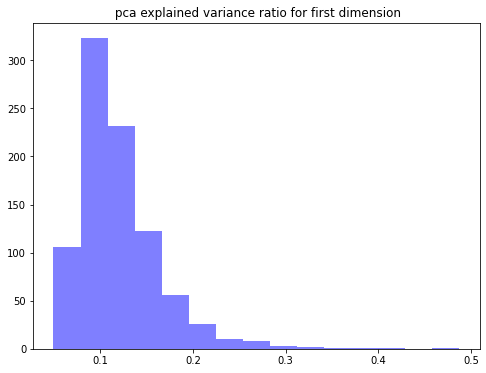

In [7]:
# visualize the distribution of variance
# Histogram of scores
raw_variance = [y for x,y in pca_source_explained]
num_bins  = 15
fig, ax = plt.subplots(figsize=(8,6))
n, bins, patches = ax.hist(raw_variance, num_bins, facecolor='blue', alpha=0.5)
plt.title(r' pca explained variance ratio for first dimension')
plt.savefig('pca_explained_variance')
#plt.plot()

[]

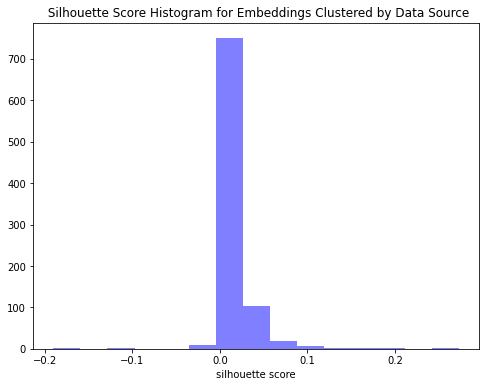

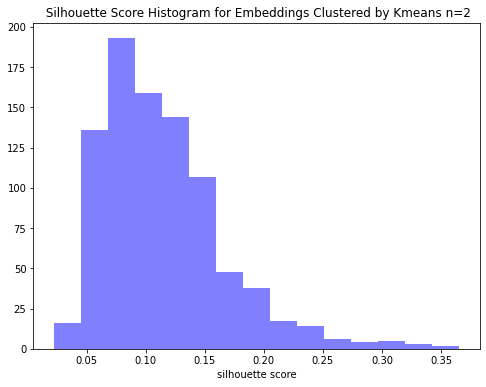

In [8]:
# visualize the distribution of scores
# Histogram of scores
num_bins  = 15
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('silhouette score')
n, bins, patches = ax.hist(raw_source_scores, num_bins, facecolor='blue', alpha=0.5)
plt.title(r' Silhouette Score Histogram for Embeddings Clustered by Data Source')
#plt.savefig('eval_silhouette_hist')
plt.plot()

# Histogram of scores
num_bins  = 15
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('silhouette score')
n, bins, patches = ax.hist(raw_kmeans_scores, num_bins, facecolor='blue', alpha=0.5)
plt.title(r' Silhouette Score Histogram for Embeddings Clustered by Kmeans n=2')
#plt.savefig('eval_silhouette_hist')
plt.plot()

In [19]:
# sort the scores and also create a separate list for termss of interest
source_scores = []
interest_term_source_scores = []
for word in silhouette_source_scores:
    if word in special_terms_cleaned:
        interest_term_source_scores.append((word,silhouette_source_scores[word]))
    source_scores.append((word,silhouette_source_scores[word]))
interest_term_source_scores.sort(key=lambda x:x[1])
source_scores.sort(key=lambda x:x[1])


kmeans_scores = []
interest_term_kmeans_scores = []
for word in silhouette_kmeans_scores:
    if word in special_terms_cleaned:
        interest_term_kmeans_scores.append((word,silhouette_kmeans_scores[word]))
    kmeans_scores.append((word,silhouette_kmeans_scores[word]))
interest_term_kmeans_scores.sort(key=lambda x:x[1])
kmeans_scores.sort(key=lambda x:x[1])

In [46]:
print("Highest and Lowest Source Scores for Interest Terms\n")
print(interest_term_source_scores[-10:])
print(interest_term_source_scores[:10])
print("\nHighest and Lowest Source Scores for All Terms\n")
print(source_scores[-10:])
print(source_scores[:10])

Highest and Lowest Source Scores for Interest Terms

[('original jurisdiction', 0.036305662), ('raise and support', 0.037826072), ('capita##tion', 0.03841069), ('good behavior', 0.040099114), ('rep##el invasions', 0.04085832), ('recess', 0.058242165), ('compulsory process', 0.08437641), ('in law', 0.091445416), ('here##in granted', 0.093416534), ('maritime jurisdiction', 0.16168946)]
[('cruel and unusual', -0.19026864), ('confrontation', -0.102428764), ('new hampshire', -0.0030612794), ('confederation', -0.0028550795), ('commerce', 0.0012016972), ('consul##s', 0.0022863129), ('treaty', 0.0023344043), ('law of nations', 0.00311155), ('probable cause', 0.0034873988), ('direct taxes', 0.0041546565)]

Highest and Lowest Source Scores for All Terms

[('ex##pire', 0.08960522), ('in law', 0.091445416), ('jacob', 0.092650026), ('here##in granted', 0.093416534), ('faith', 0.09712985), ('vice', 0.09859748), ('lord', 0.13058089), ('maritime jurisdiction', 0.16168946), ('honor', 0.20207837), ('nat

In [49]:
print("Highest and Lowest K_Means=2 Scores for Interest Terms\n")
print(interest_term_kmeans_scores[-10:])
print(interest_term_kmeans_scores[:10])

print("\nHighest and Lowest K_Means Scores for All Terms\n")
print(kmeans_scores[-10:])
print(kmeans_scores[:10])

Highest and Lowest K_Means=2 Scores for Interest Terms

[('confronted', 0.21523143), ('suppress insurrection##s', 0.21933217), ('in law', 0.22866207), ('compulsory process', 0.2345114), ('raise and support', 0.23475155), ('felony', 0.25612876), ('maritime jurisdiction', 0.26332915), ('receive ambassadors', 0.26499423), ('confrontation', 0.29704794), ('here##in granted', 0.3655133)]
[('commission', 0.051050786), ('new hampshire', 0.05238717), ('executive power', 0.055658408), ('jury', 0.06263547), ('grand jury', 0.0662714), ('law of nations', 0.067749284), ('bear arms', 0.08178925), ('witness', 0.08477599), ('natural born', 0.0857445), ('executive', 0.08866575)]

Highest and Lowest K_Means Scores for All Terms

[('confrontation', 0.29704794), ('intent##s', 0.30377525), ('jeopardy', 0.30505022), ('natural born citizen', 0.30714497), ('mar##que', 0.31090367), ('united', 0.3334552), ('corpus', 0.3335509), ('offenses', 0.3381952), ('tempo##re', 0.35267532), ('here##in granted', 0.3655133)]


[]

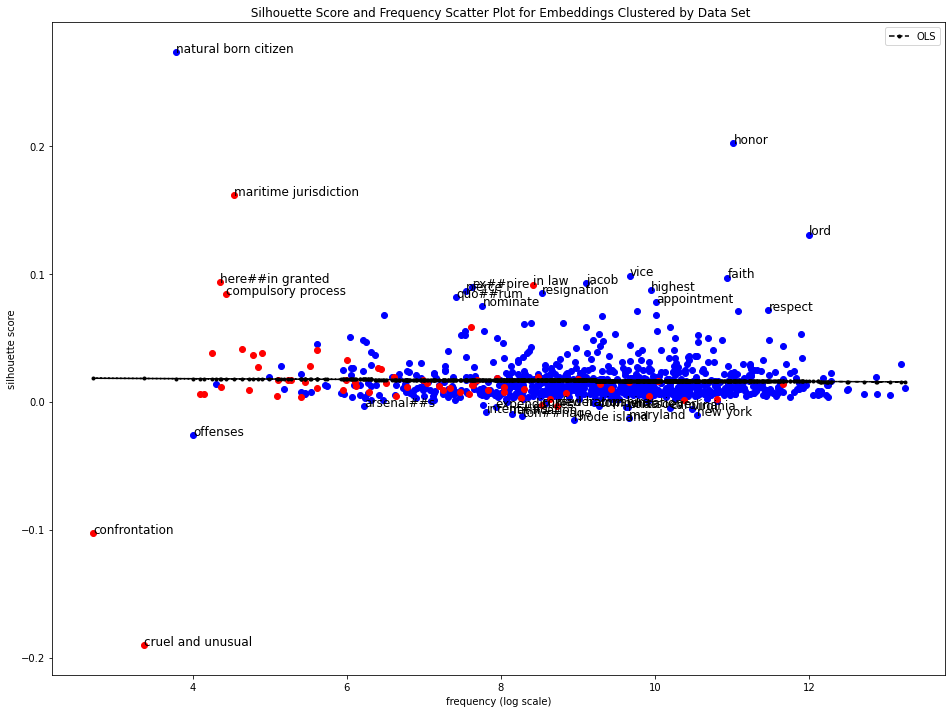

In [12]:
# scores and frequency

# total frequency across both data sets
model = sm.OLS(raw_source_scores, sm.add_constant(source_frequency_data))
results = model.fit()
fig, ax = plt.subplots(figsize=(16,12))

ax.plot(source_frequency_data,results.fittedvalues, 'k--.', label="OLS")
ax.legend(loc='best')

top = np.percentile(raw_source_scores,98)
bottom = np.percentile(raw_source_scores,2)
target_x = []
target_y = []
x = []
y = []
for i, word in enumerate(source_terms):
    if word in special_terms_cleaned:
        target_x.append(source_frequency_data[i])
        target_y.append(raw_source_scores[i])
    else:
        x.append(source_frequency_data[i])
        y.append(raw_source_scores[i])

        
ax.scatter(x, y,color ='blue')        
ax.scatter(target_x, target_y,color ='red')
ax.set_ylabel('silhouette score')
ax.set_xlabel('frequency (log scale)')
top_nn_target = []
for i, word in enumerate(source_terms):
    if raw_source_scores[i] >= top or raw_source_scores[i] <= bottom :
        ax.annotate(word, (source_frequency_data[i], raw_source_scores[i]),fontsize=12)


plt.title(r' Silhouette Score and Frequency Scatter Plot for Embeddings Clustered by Data Set')
plt.plot()

[]

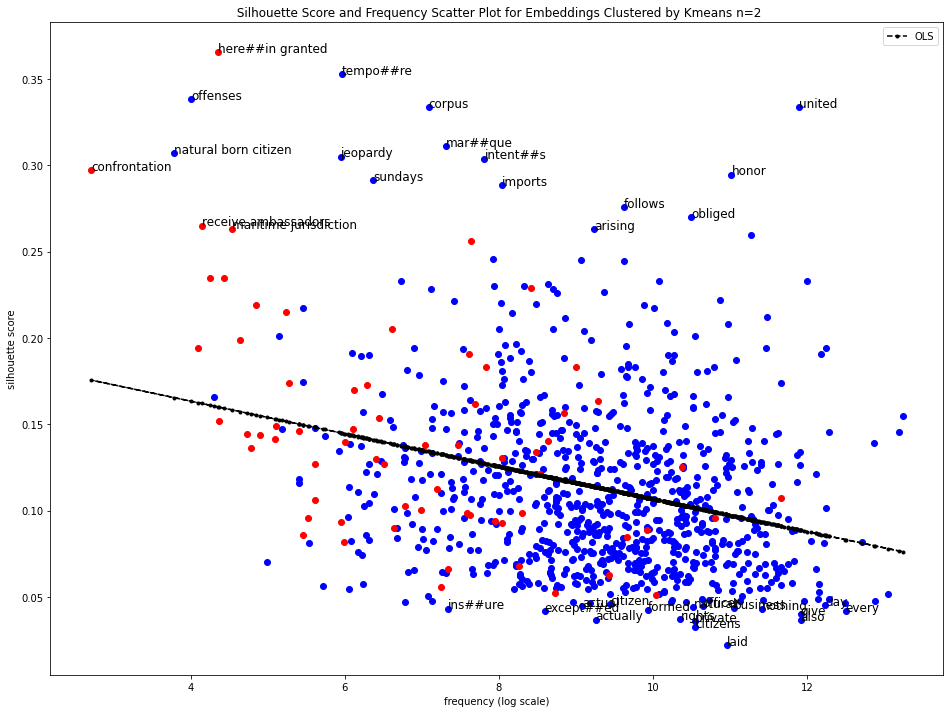

In [13]:
# total frequency across both data sets
model = sm.OLS(raw_kmeans_scores, sm.add_constant(kmeans_frequency_data))
results = model.fit()
fig, ax = plt.subplots(figsize=(16,12))

ax.plot(kmeans_frequency_data,results.fittedvalues, 'k--.', label="OLS")
ax.legend(loc='best')

top = np.percentile(raw_kmeans_scores,98)
bottom = np.percentile(raw_kmeans_scores,2)
target_x = []
target_y = []
x = []
y = []
for i, word in enumerate(kmeans_terms):
    if word in special_terms_cleaned:
        target_x.append(kmeans_frequency_data[i])
        target_y.append(raw_kmeans_scores[i])
    else:
        x.append(kmeans_frequency_data[i])
        y.append(raw_kmeans_scores[i])

        
ax.scatter(x, y,color ='blue')        
ax.scatter(target_x, target_y,color ='red')
ax.set_ylabel('silhouette score')
ax.set_xlabel('frequency (log scale)')
top_nn_target = []
for i, word in enumerate(kmeans_terms):
    if raw_kmeans_scores[i] >= top or raw_kmeans_scores[i] <= bottom :
        ax.annotate(word, (kmeans_frequency_data[i], raw_kmeans_scores[i]),fontsize=12)


plt.title(r' Silhouette Score and Frequency Scatter Plot for Embeddings Clustered by Kmeans n=2')
plt.plot()

In [14]:
def pca_viz(vectors, time_data, title, output_filename=None, figsize=(16,12), random_state=None):
    """
    2d plot of `df` using t-SNE, with the points labeled by `df.index`,
    aligned with `colors` (defaults to all black).

    Parameters
    ----------
    df : pd.DataFrame
        The matrix to visualize.

    colors : list of colornames or None (default: None)
        Optional list of colors for the vocab. The color names just
        need to be interpretable by matplotlib. If they are supplied,
        they need to have the same length as `df.index`. If `colors=None`,
        then all the words are displayed in black.

    output_filename : str (default: None)
        If not None, then the output image is written to this location.
        The filename suffix determines the image type. If `None`, then
        `plt.plot()` is called, with the behavior determined by the
        environment.

    figsize : (int, int) (default: (40, 50))
        Default size of the output in display units.

    random_state : int or None
        Optionally set the `random_seed` passed to `PCA` and `TSNE`.

    """
    # Colors:
    color_labels = {'post_constitution':'red',
                     'pre_constitution':'blue',
                     
    }
    #make colors
    colors = []
    for period in time_data:
        colors.append(color_labels[period])
                
    # Recommended reduction via PCA or similar:
    dimreduce = PCA(n_components=2, random_state=random_state)
    X = dimreduce.fit_transform(vectors)
    
    # t-SNE:
    #tsne = TSNE(n_components=2, random_state=random_state)
    #tsnemat = tsne.fit_transform(X)
    
    # Plot values:
    xvals = X[: , 0]
    yvals = X[: , 1]
     # Plotting:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax.plot(xvals, yvals, marker='', linestyle='')
    # Color labels
    # not sure how to add color legend
    for x, y, color in zip(xvals, yvals, colors):
        try:
            ax.scatter(x, y,color =color)
        except UnicodeDecodeError:  ## Python 2 won't cooperate!
            pass
    plt.title(title)
    # Output:
    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight')
    else:
        plt.show()

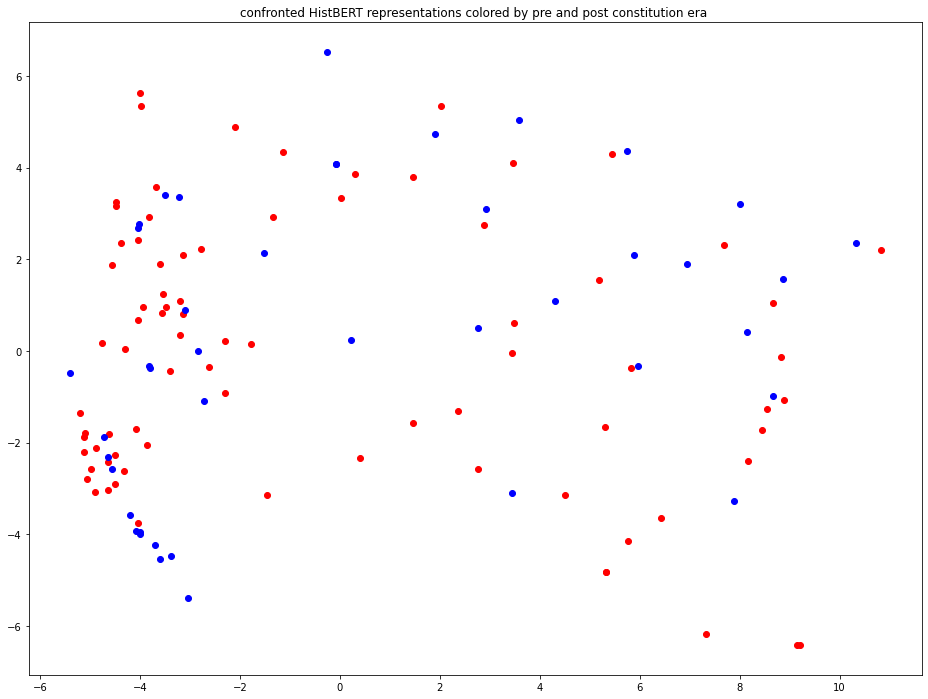

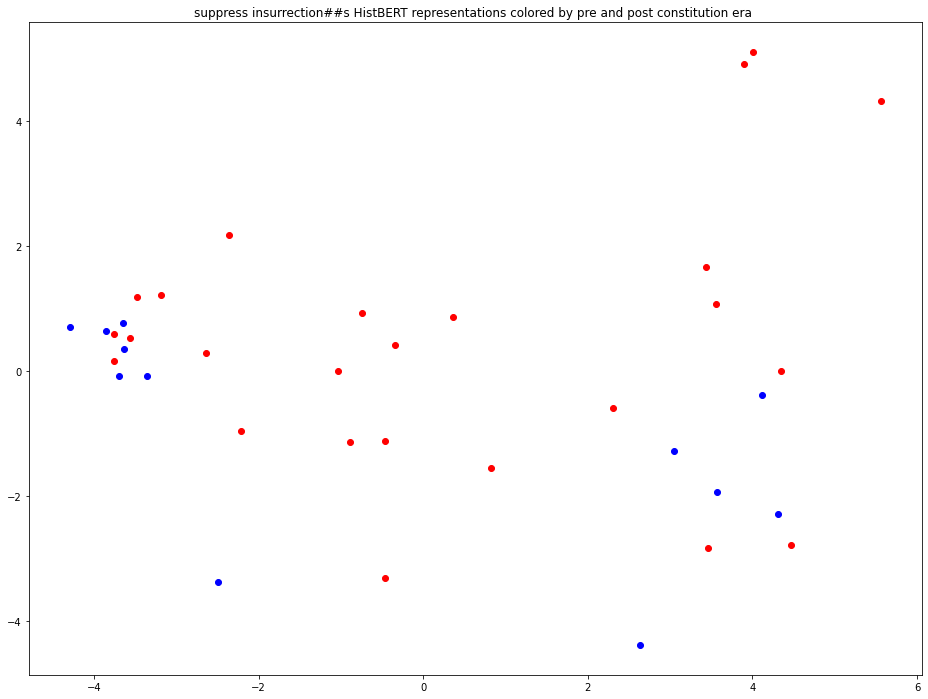

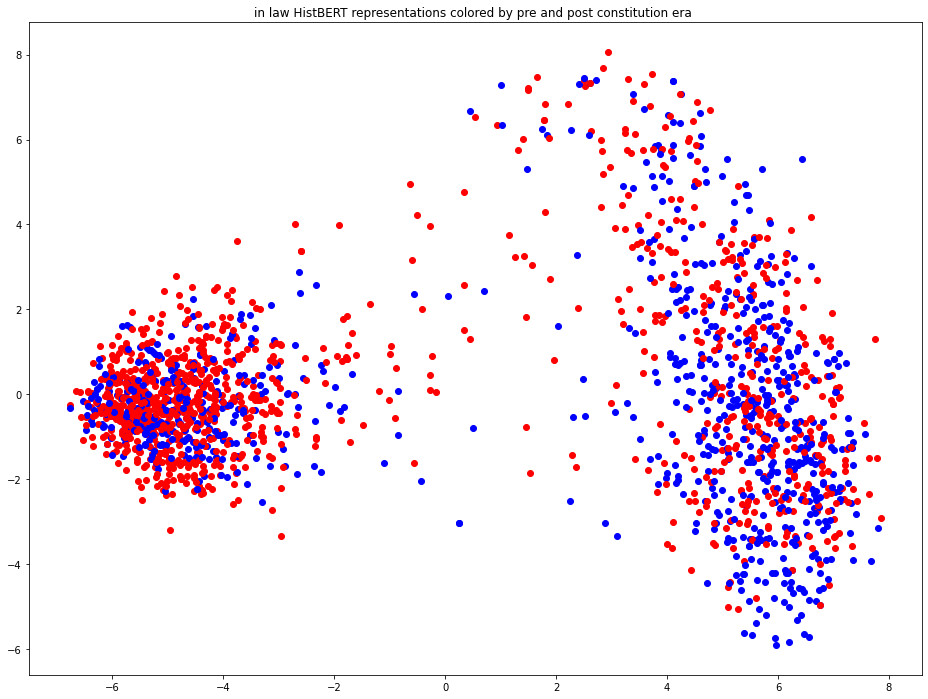

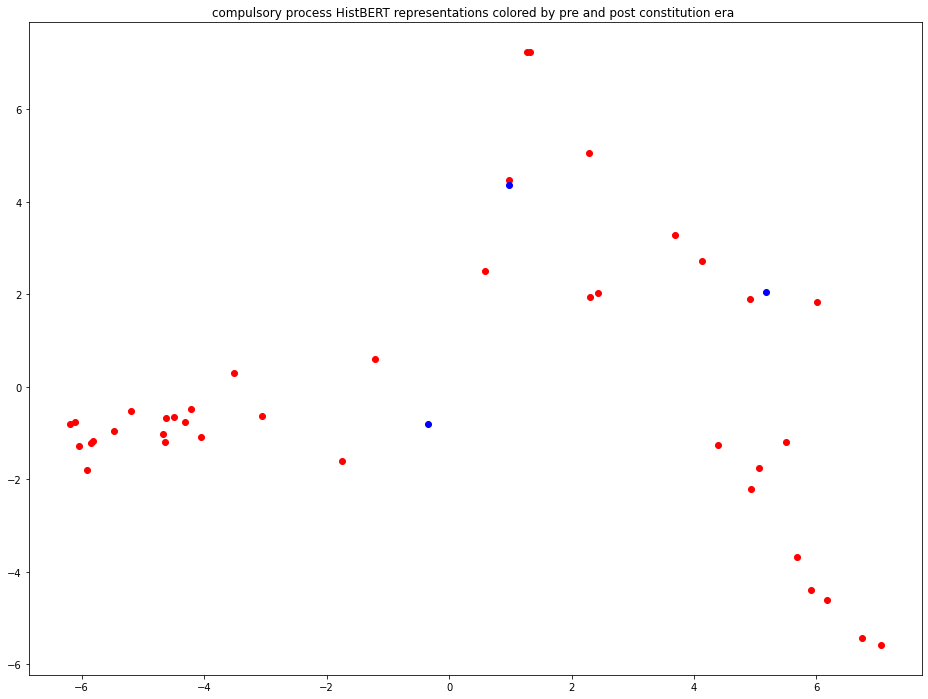

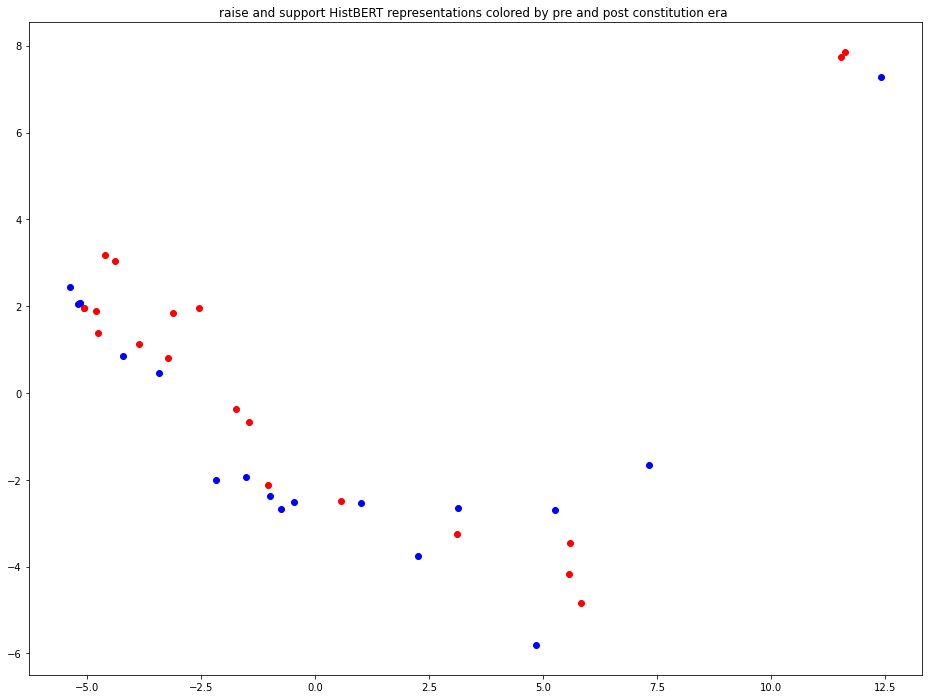

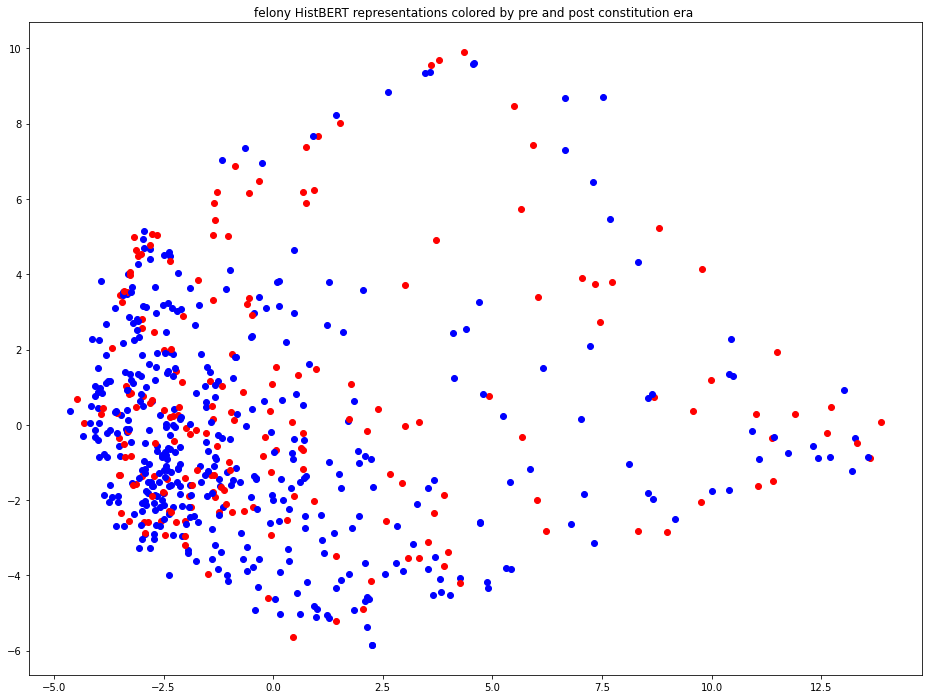

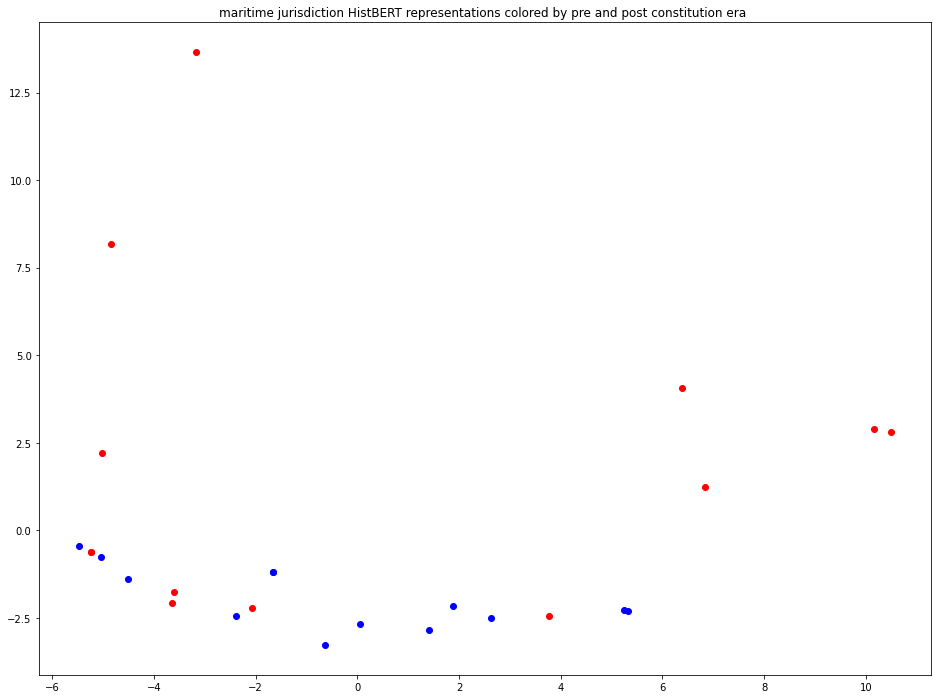

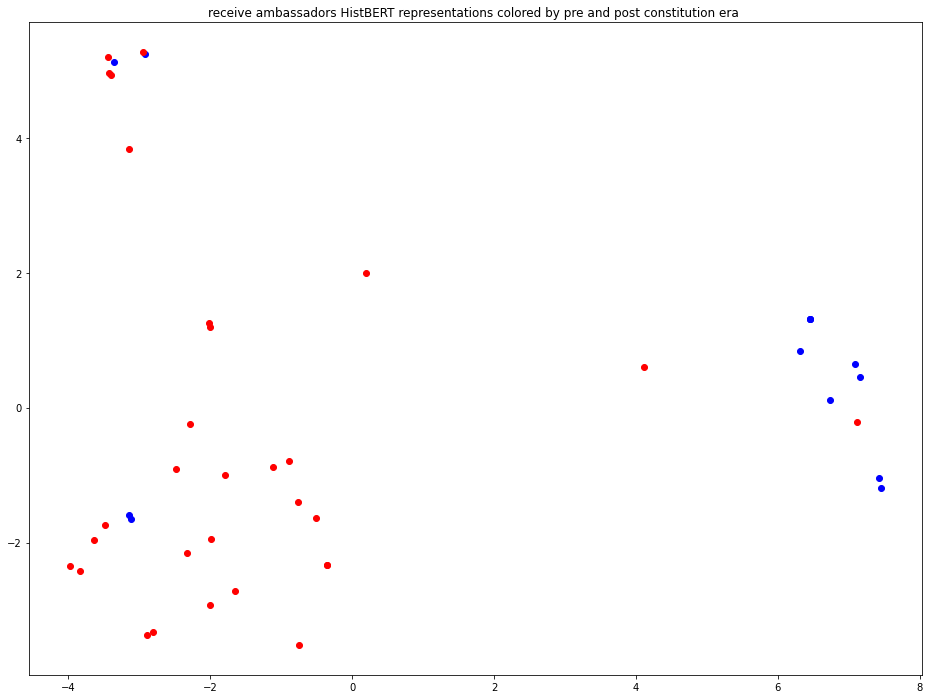

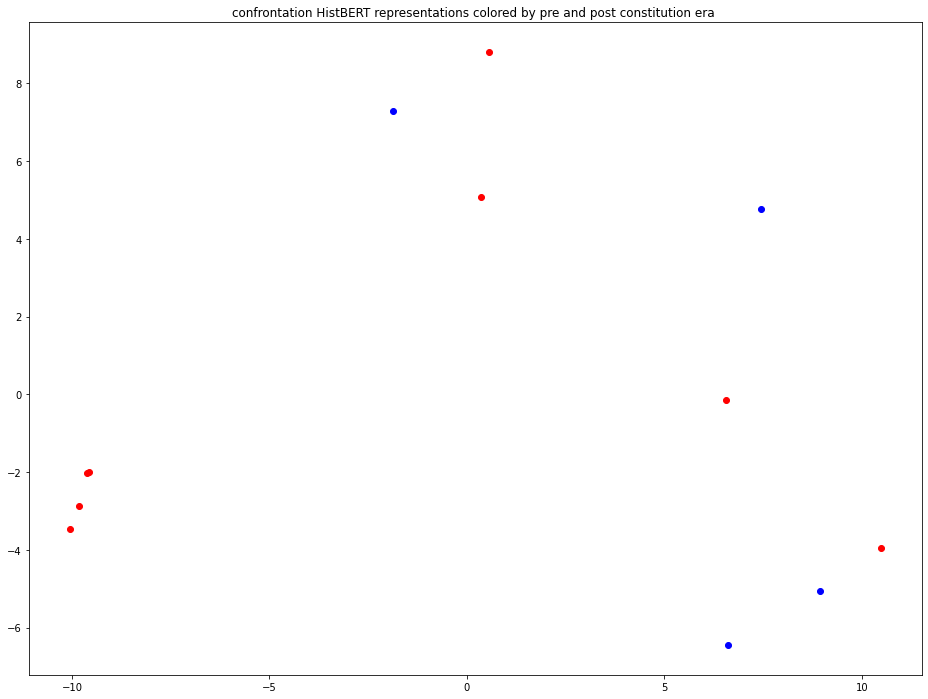

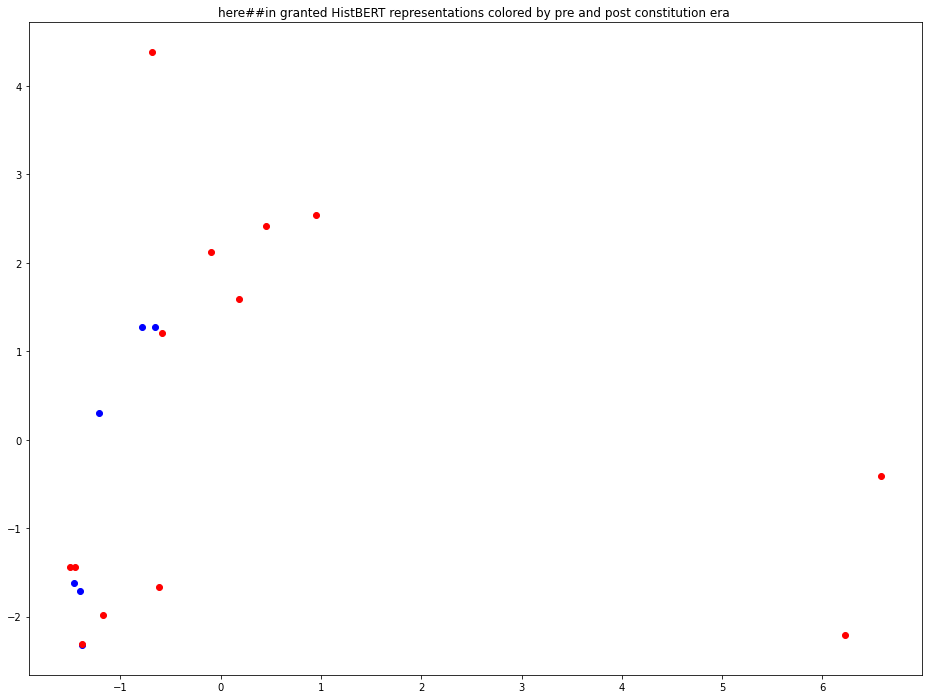

In [15]:
# interest terms visualize the clusters based on time period
# also measure silhouette score based on time period
# highest score
graphics_terms = [ term for term,score in 
                 interest_term_kmeans_scores[-10:]+interest_term_source_scores[-10:]]
for term in set(graphics_terms):
    # get the labels
    date_info = []
    for f_ind,doc_ind,ind in sample_index[term]:
        doc = json.loads(cofea_data[doc_ind])
        if doc['decade'] > 1780:
            date_info.append('post_constitution')
        else:
            date_info.append('pre_constitution')
    # load embeddings
    with open(join(embedding_dir,file_header+term+'.dict'),'rb') as f:
        target_embeddings = pickle.load(f)
    embeddings = target_embeddings[layer]
    pca_viz(embeddings, date_info, term + " HistBERT representations colored by pre and post constitution era "
             ,join(outdir,term+'_histbert_tsne_pre_post_constitution'))



100%|███████████████████████████████████████████| 20/20 [10:21<00:00, 31.10s/it]


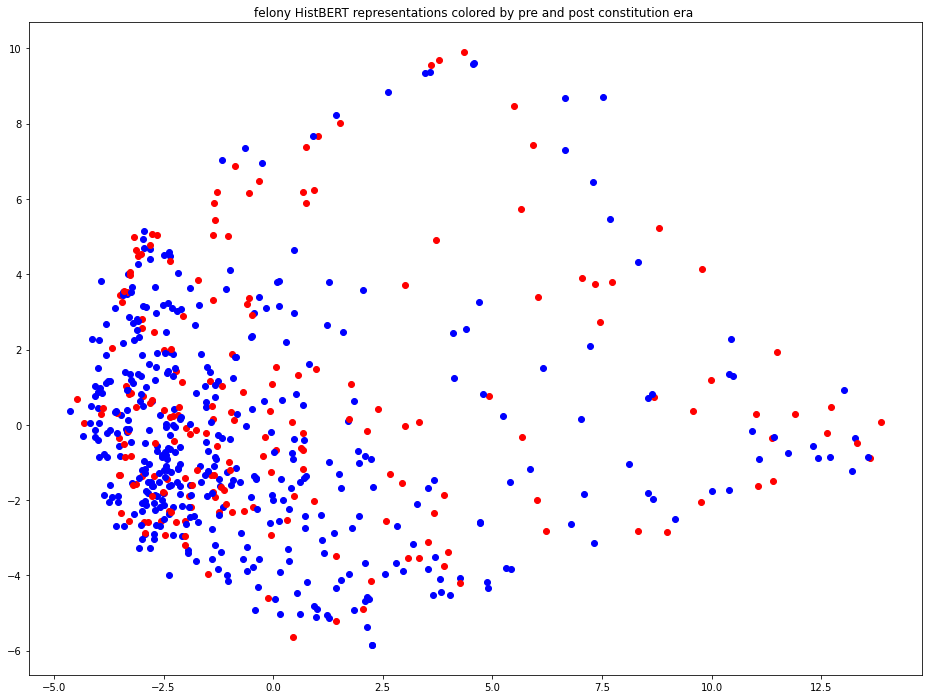

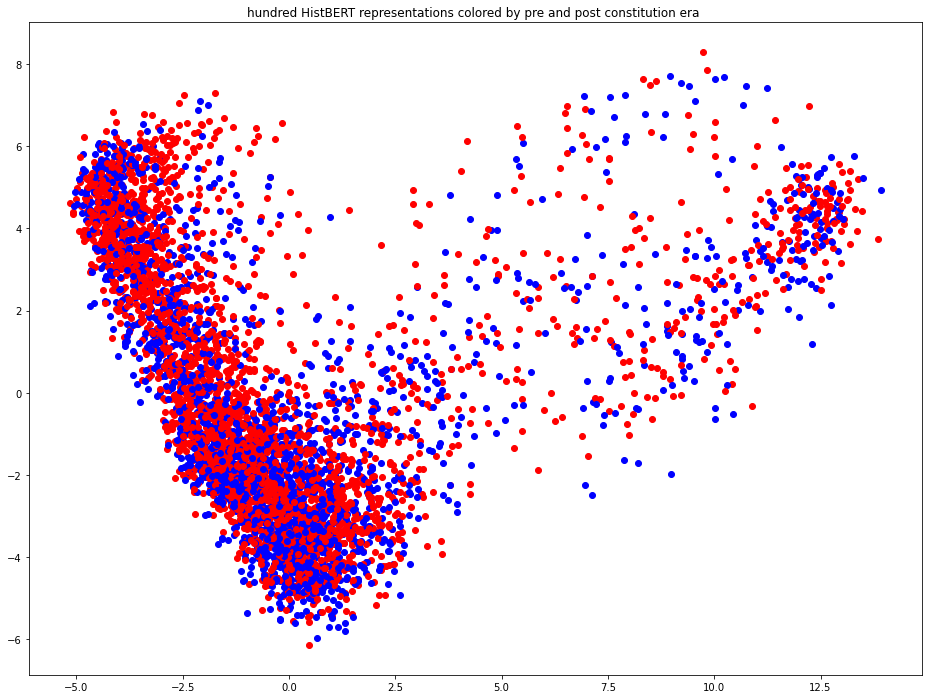

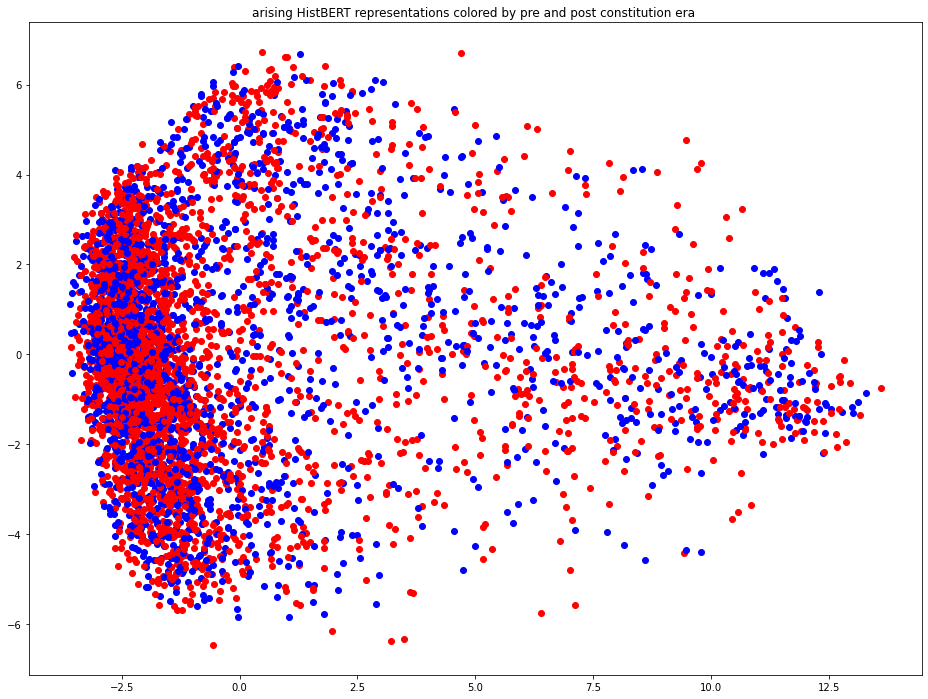

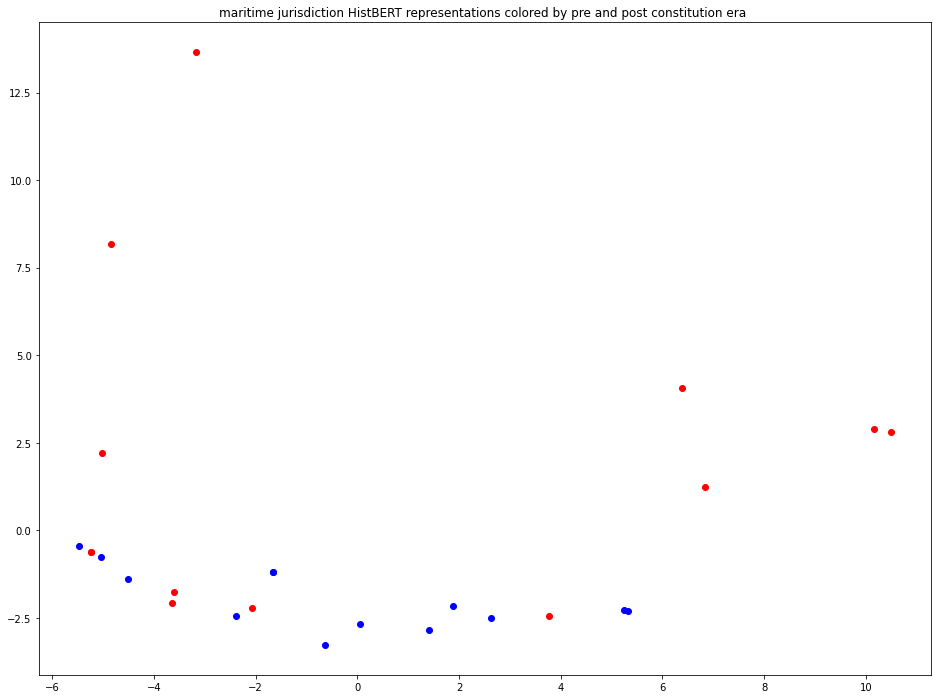

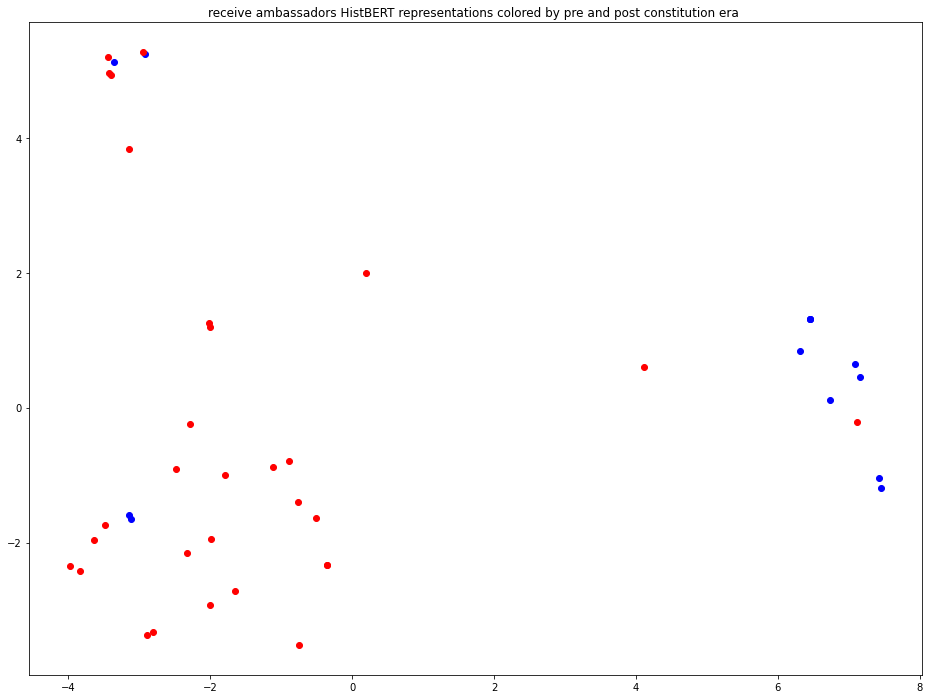

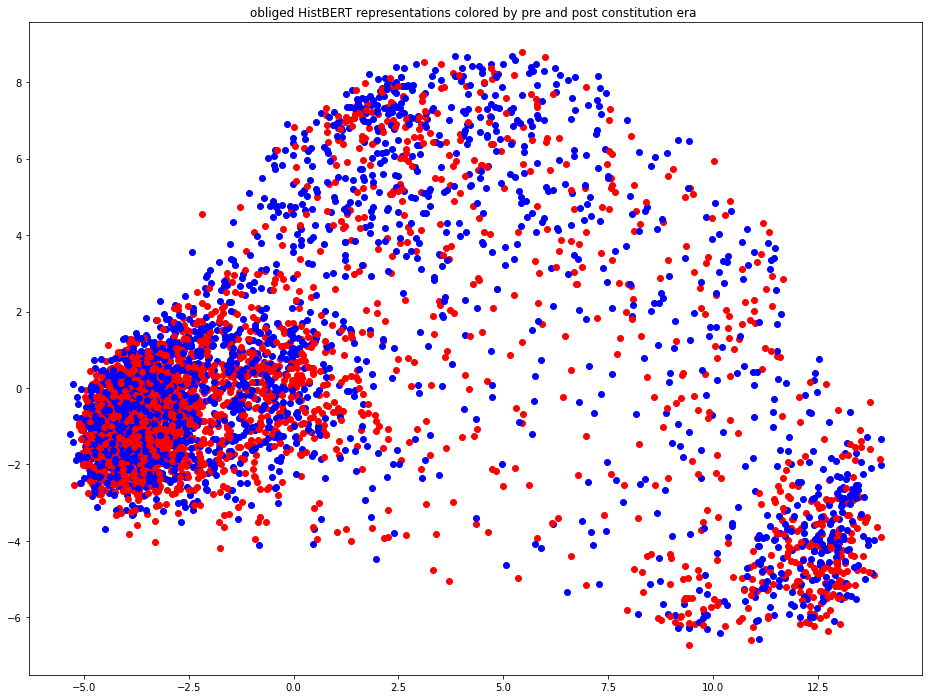

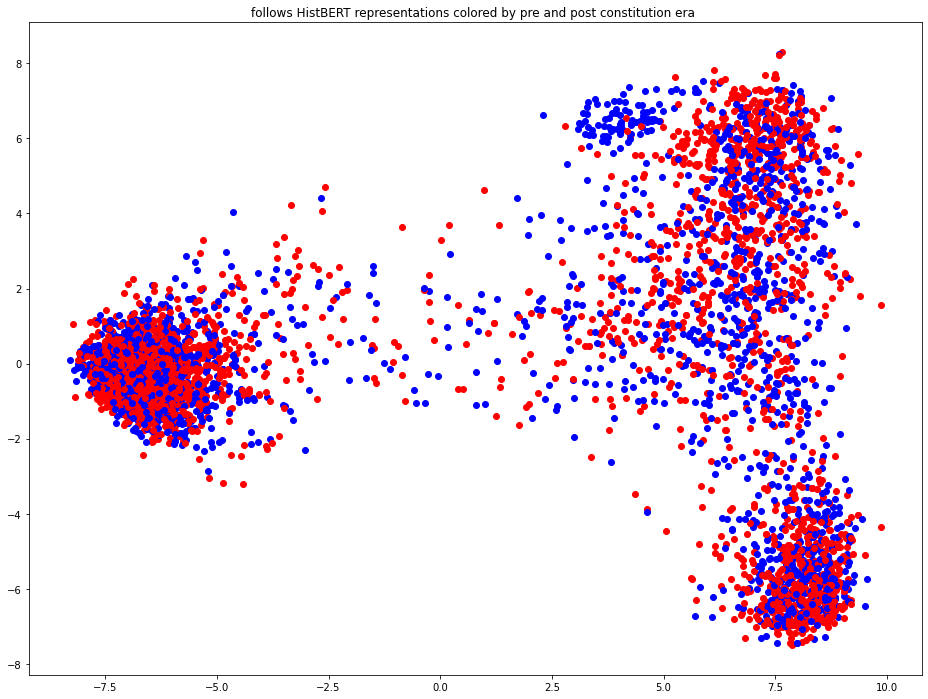

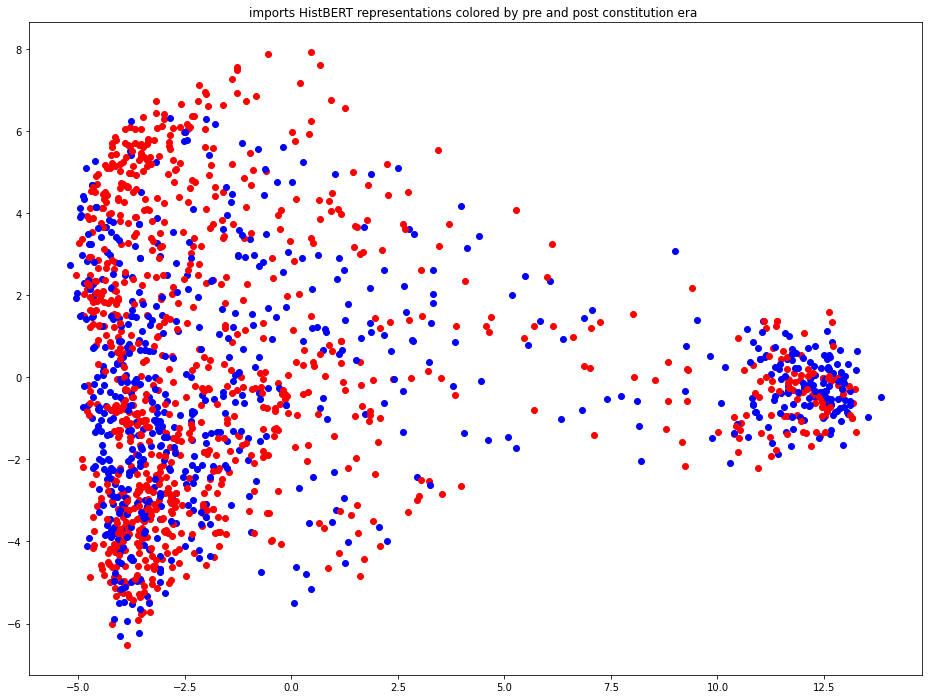

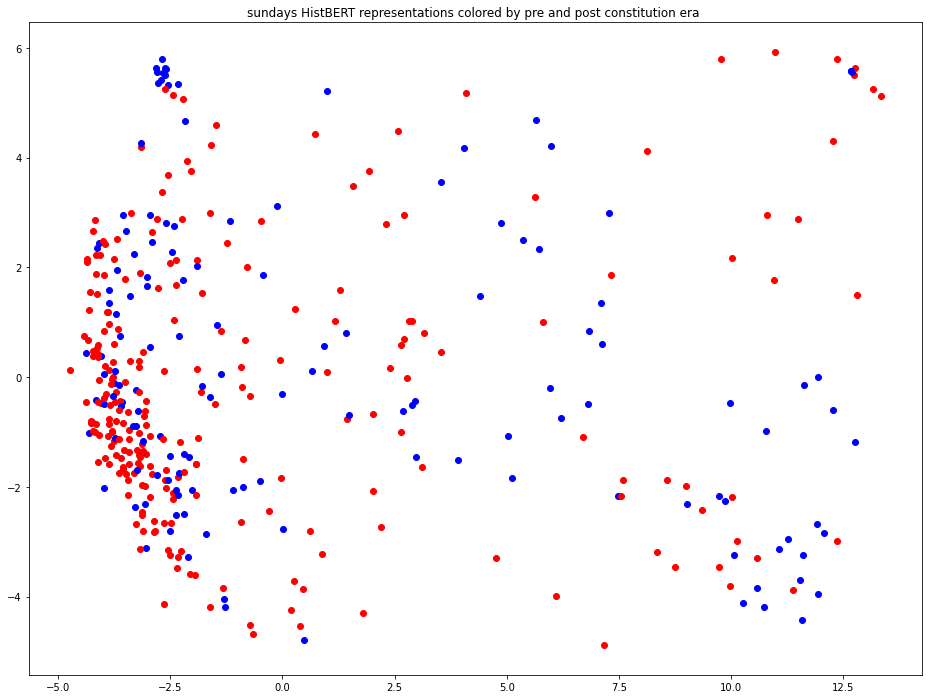

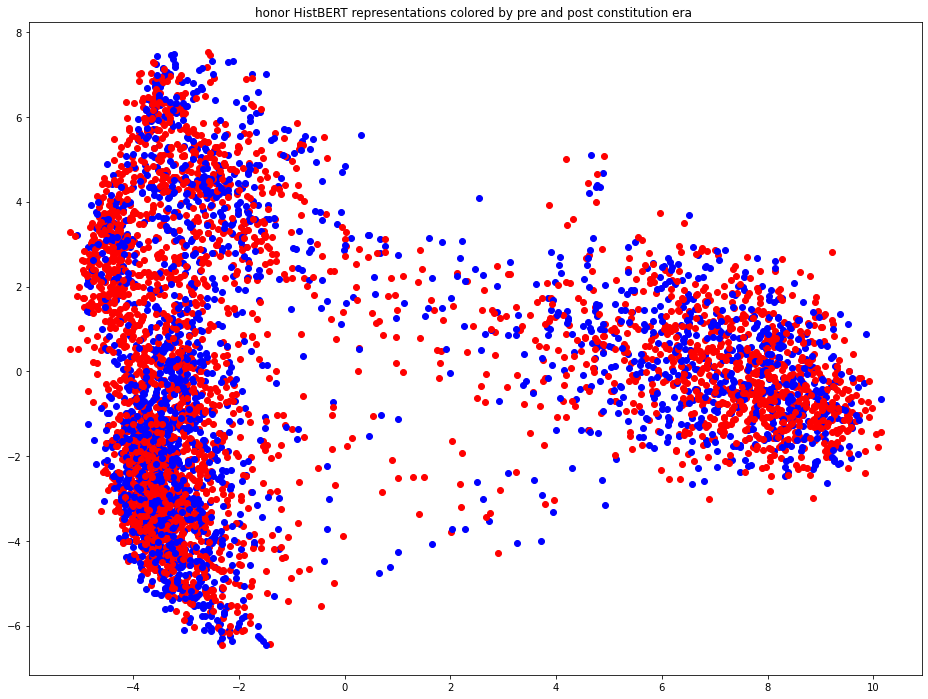

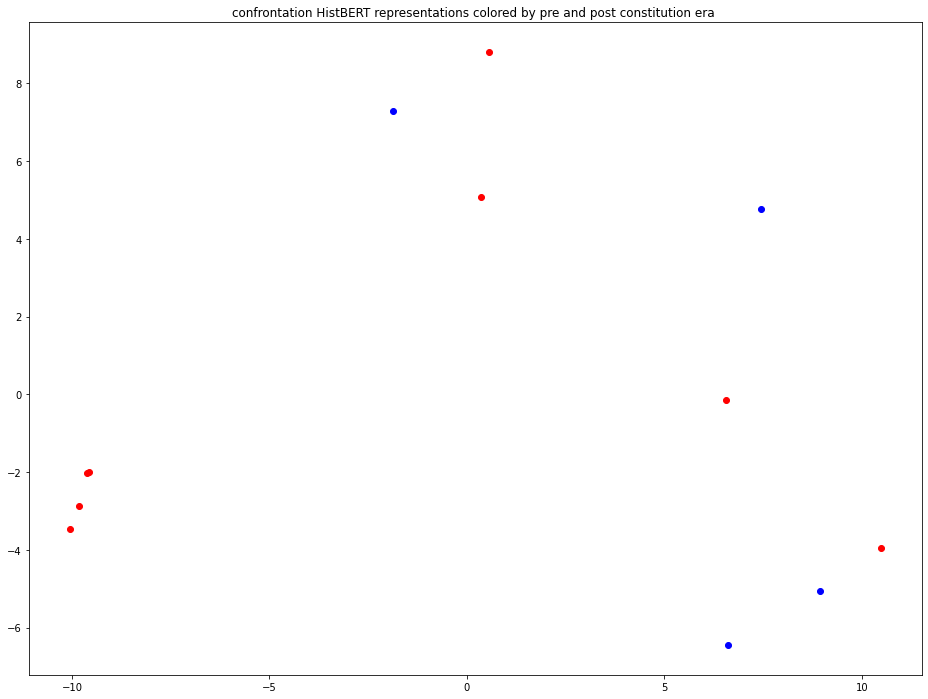

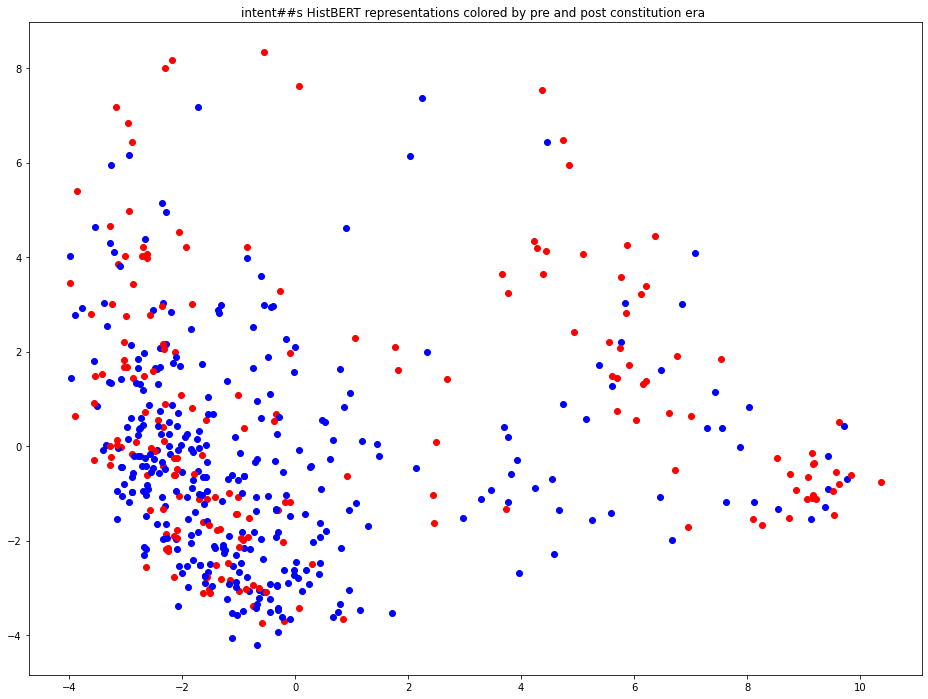

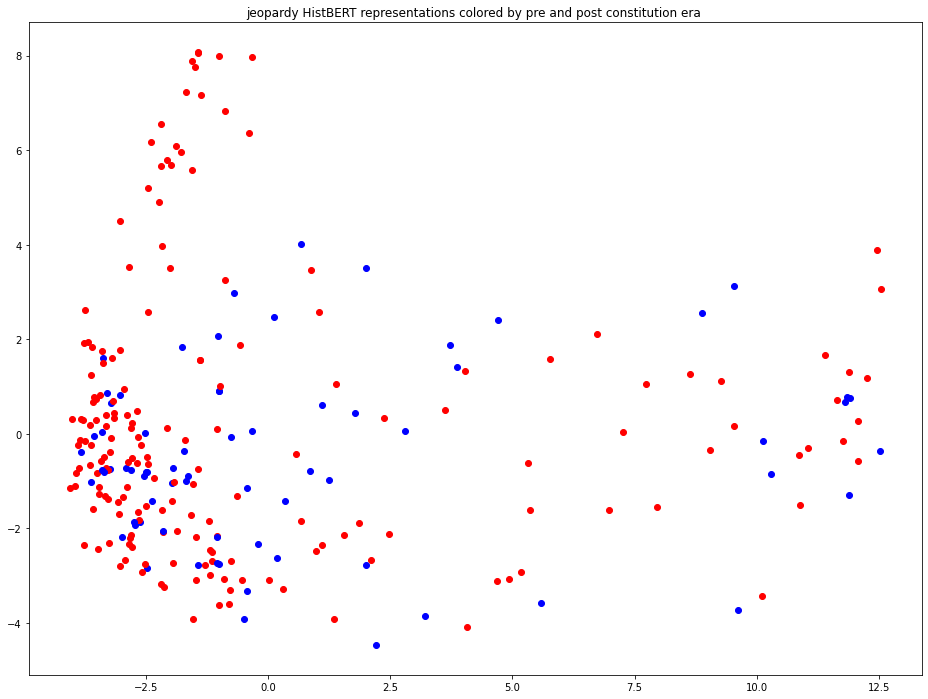

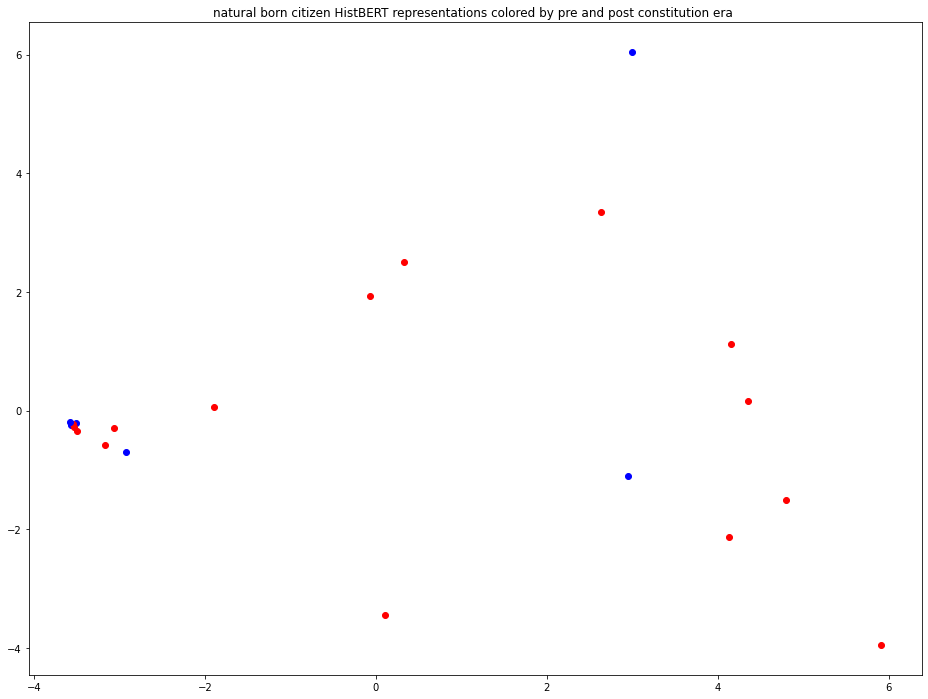

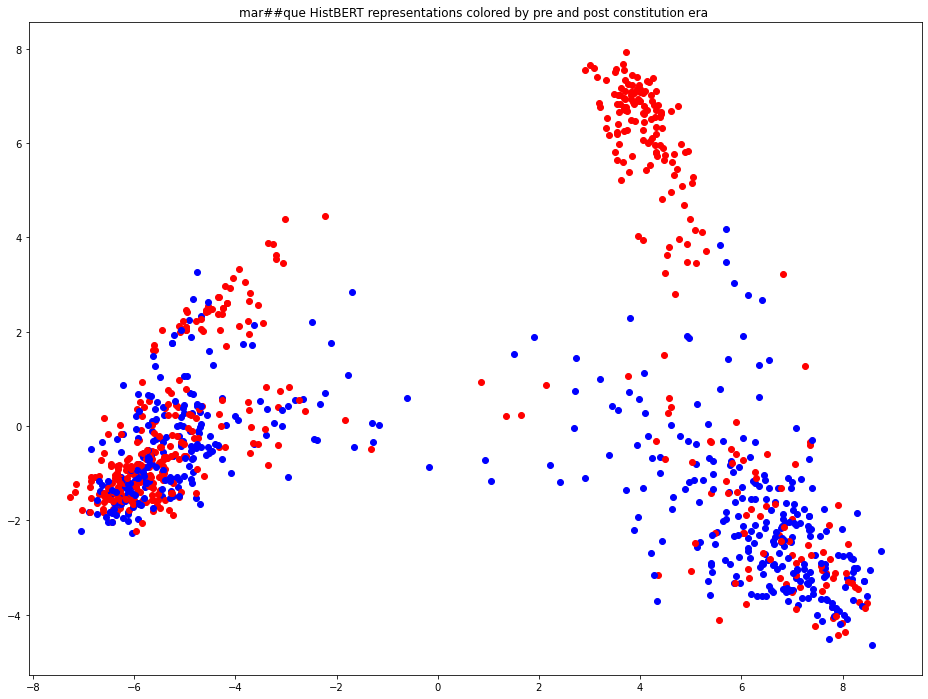

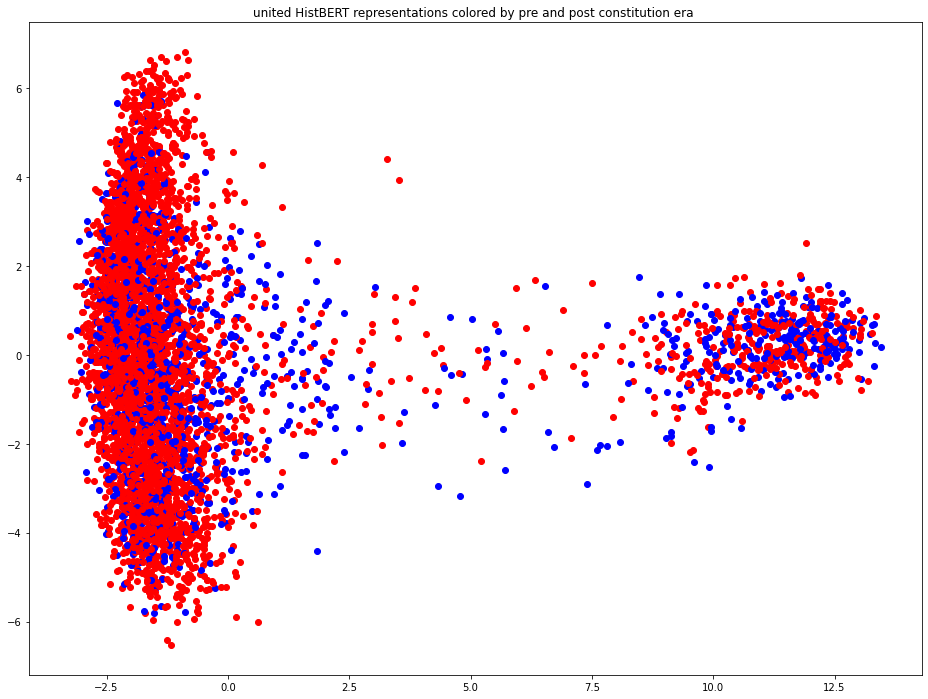

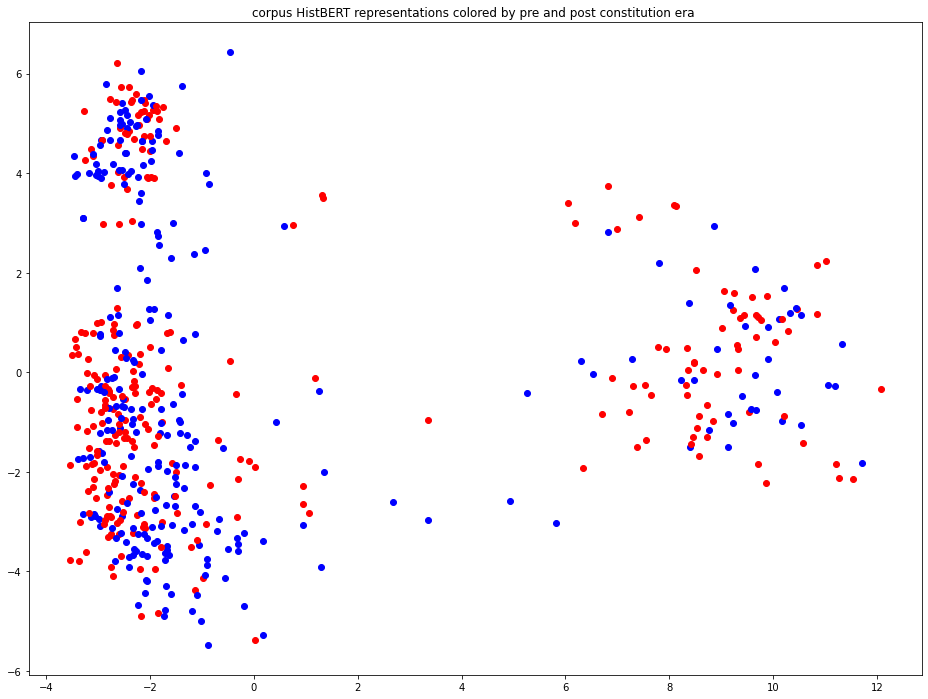

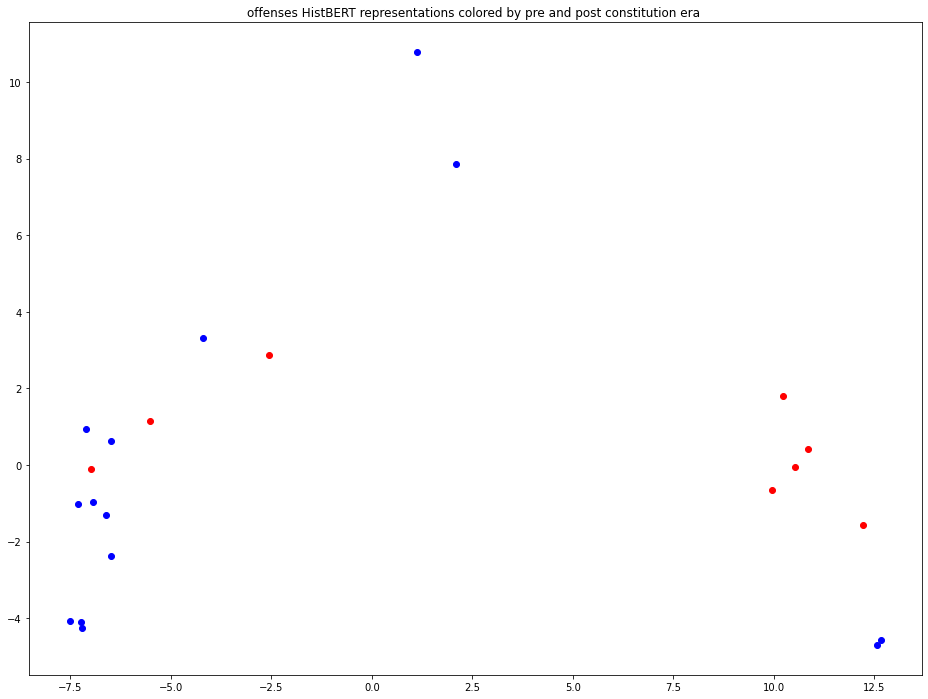

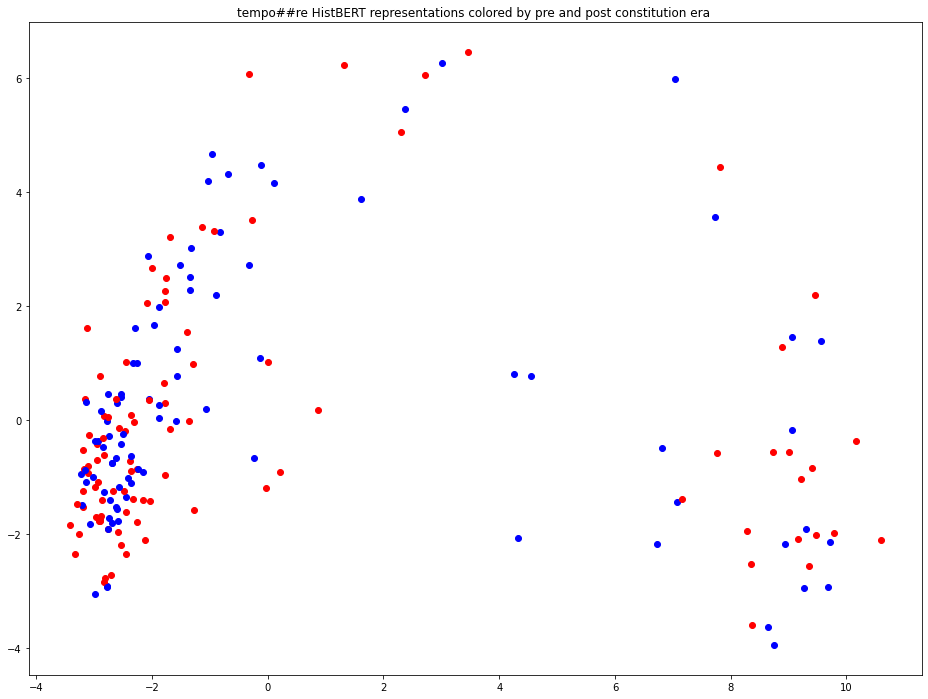

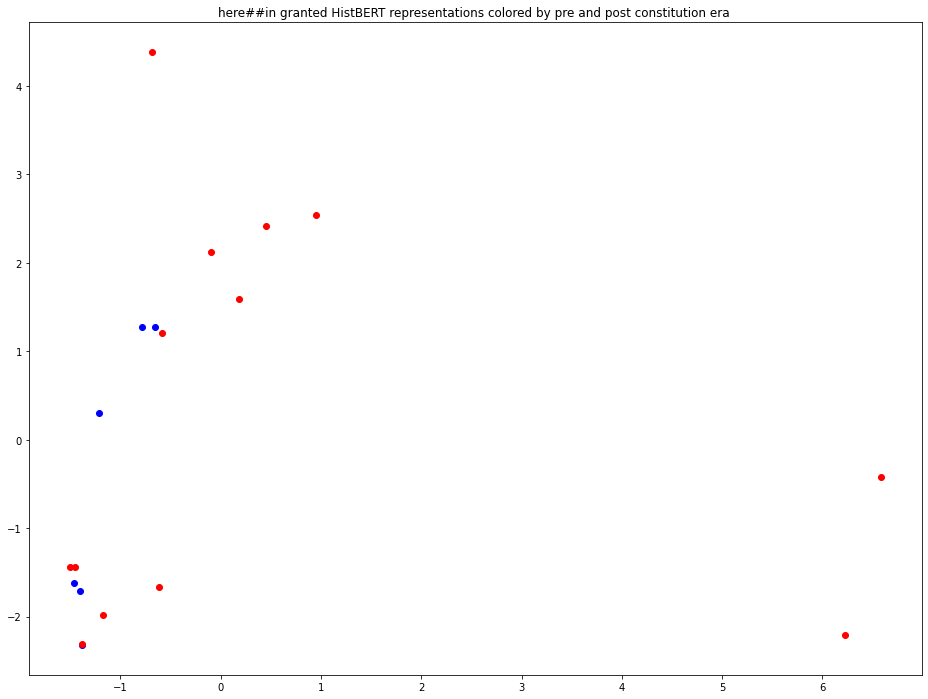

In [51]:
# visualize the clusters based on time period for all terms with score > .25
graphics_terms = [ term for term,score in kmeans_scores if .25 < score  ]
for term in tqdm(graphics_terms):
    # get the labels
    date_info = []
    for f_ind,doc_ind,ind in sample_index[term]:
        doc = json.loads(cofea_data[doc_ind])
        if doc['decade'] > 1780:
            date_info.append('post_constitution')
        else:
            date_info.append('pre_constitution')
    # load embeddings
    with open(join(embedding_dir,file_header+term+'.dict'),'rb') as f:
        target_embeddings = pickle.load(f)
    embeddings = target_embeddings[layer]
    pca_viz(embeddings, date_info, term + " HistBERT representations colored by pre and post constitution era "
             ,join(outdir,term+'_histbert_tsne_pre_post_constitution'))

100%|███████████████████████████████████████████| 18/18 [12:09<00:00, 40.53s/it]


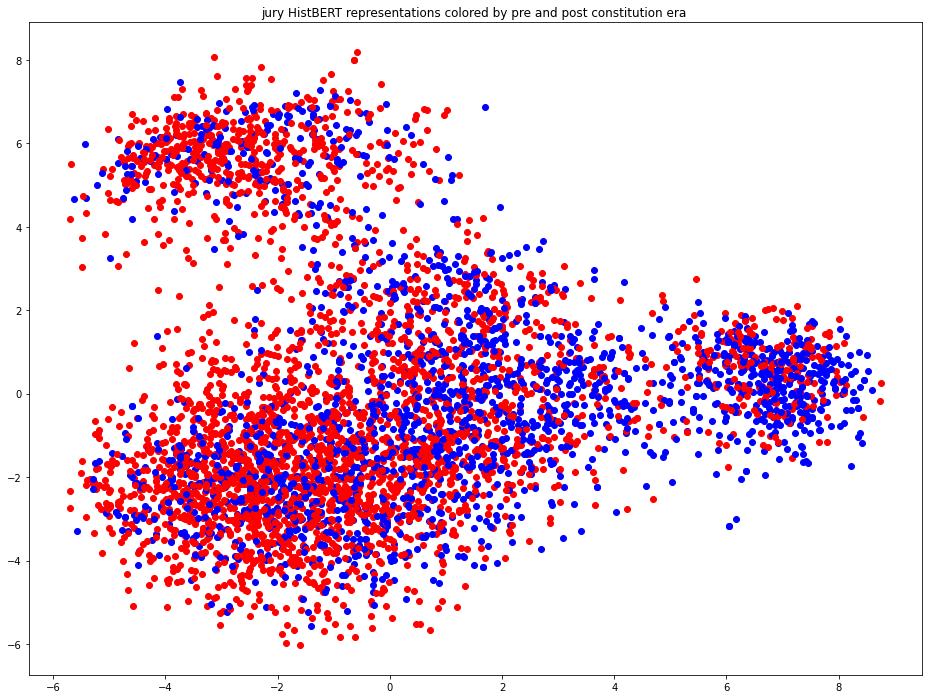

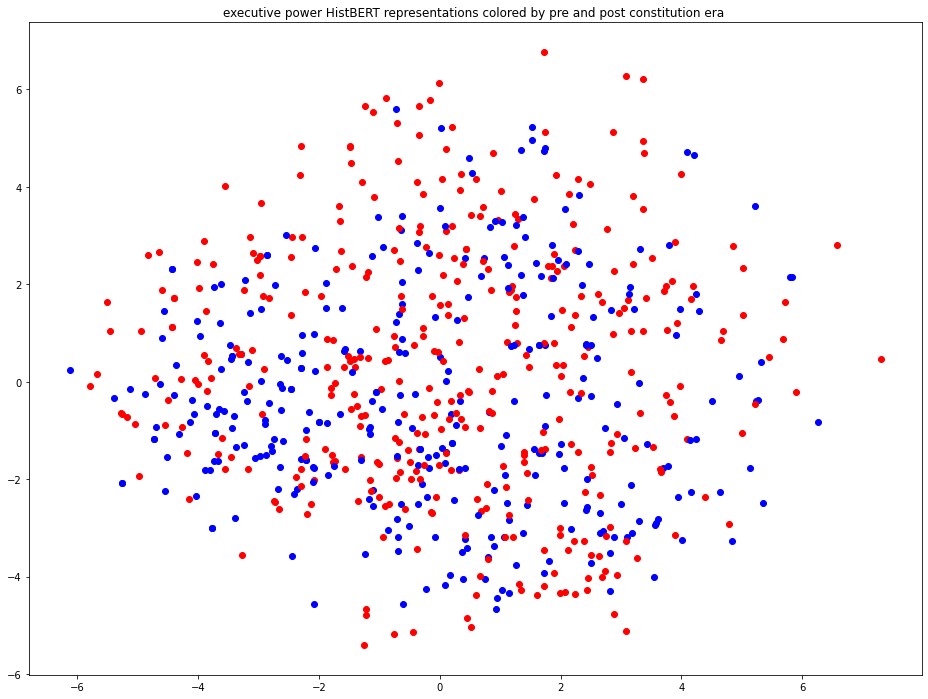

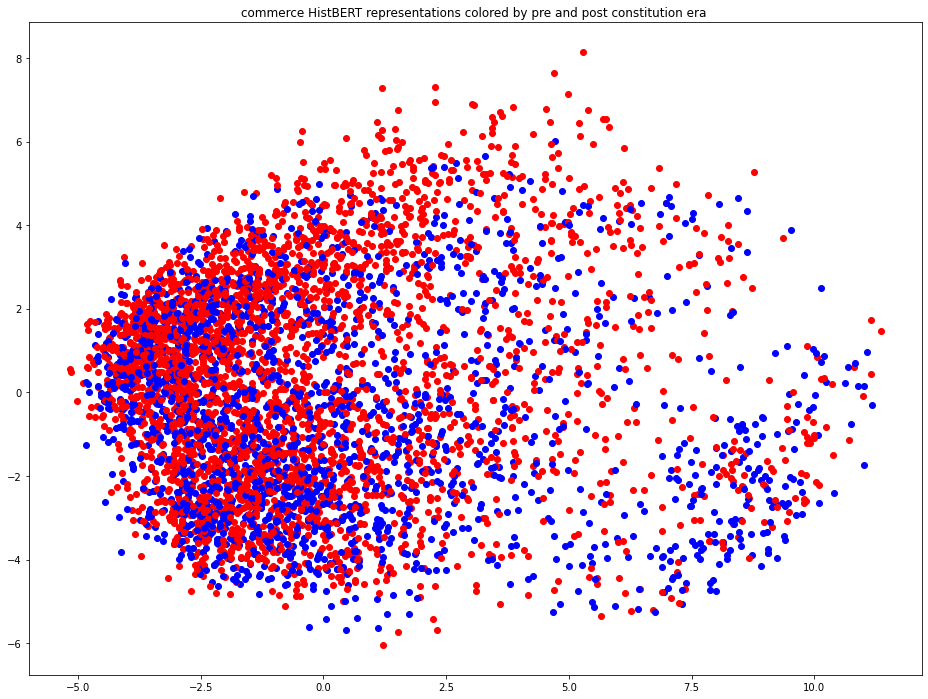

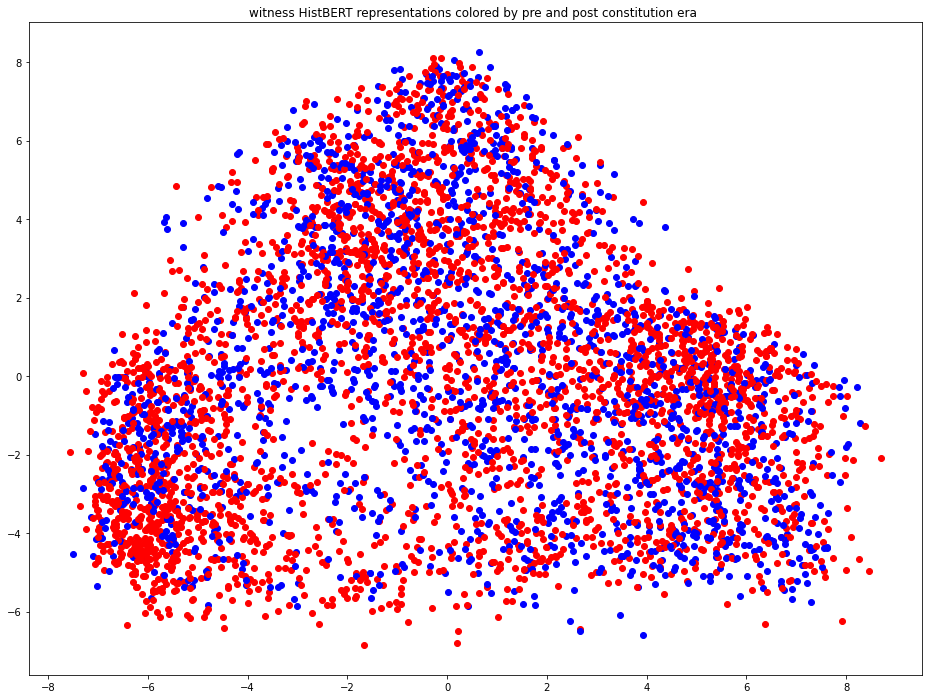

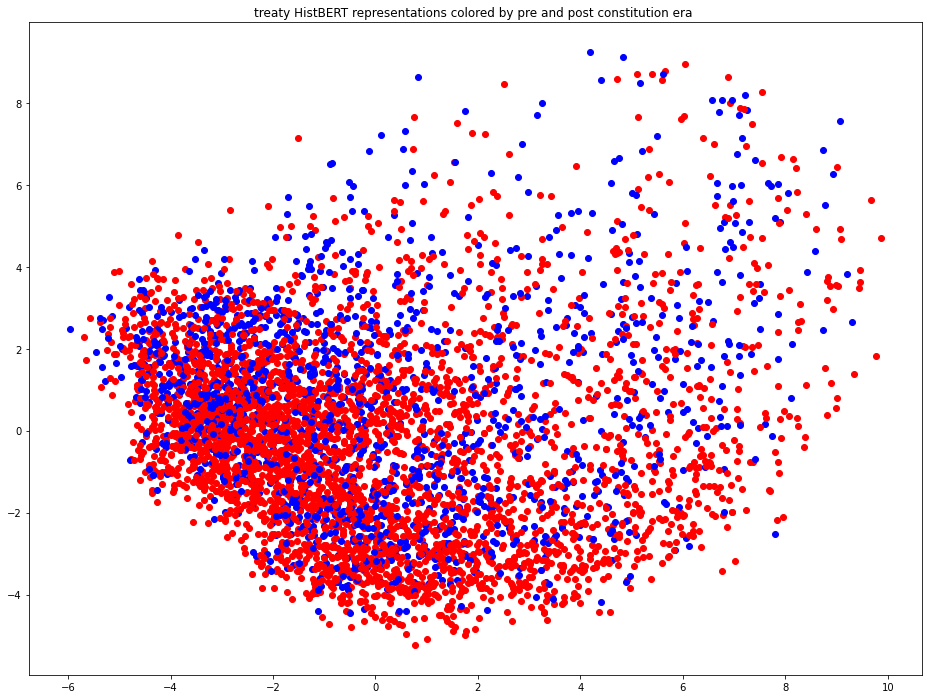

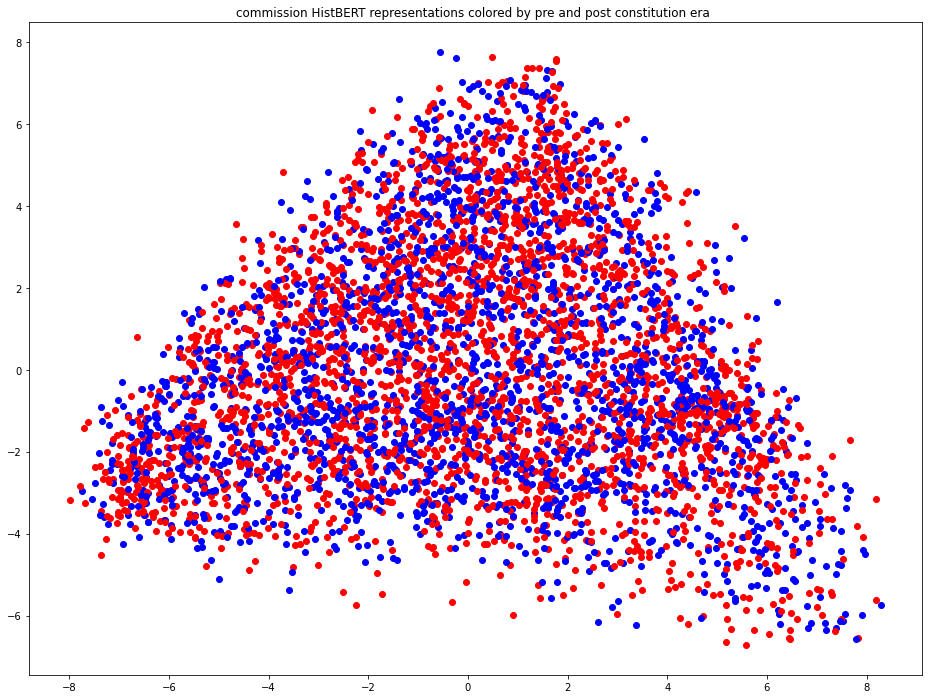

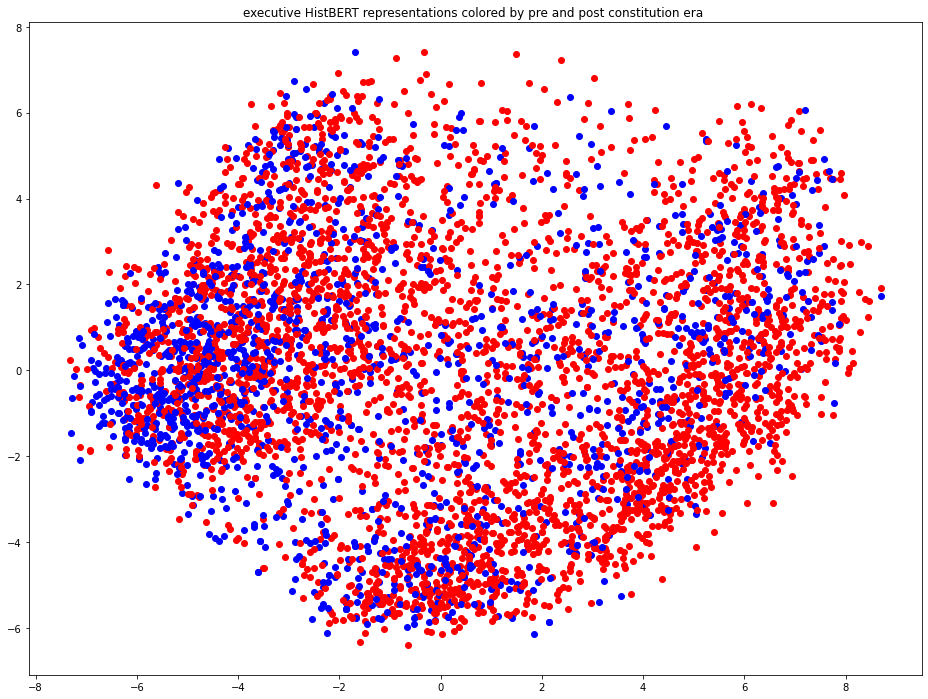

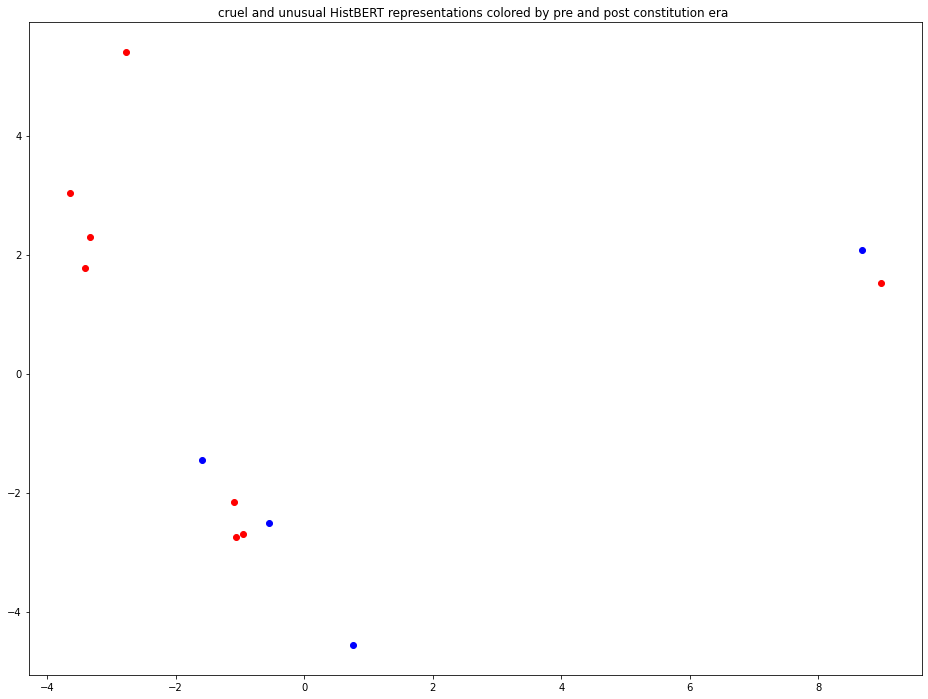

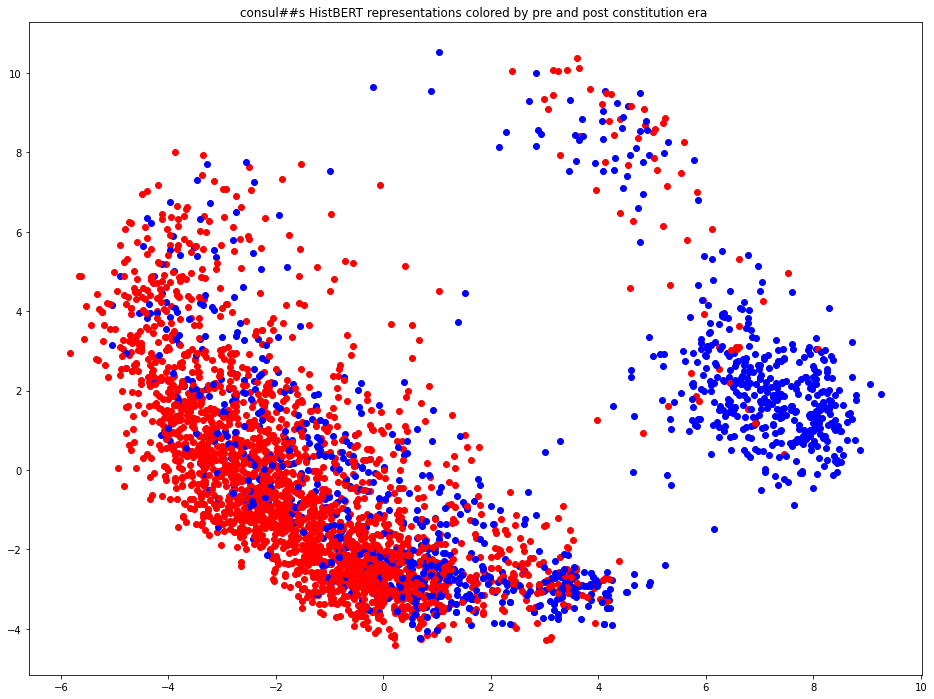

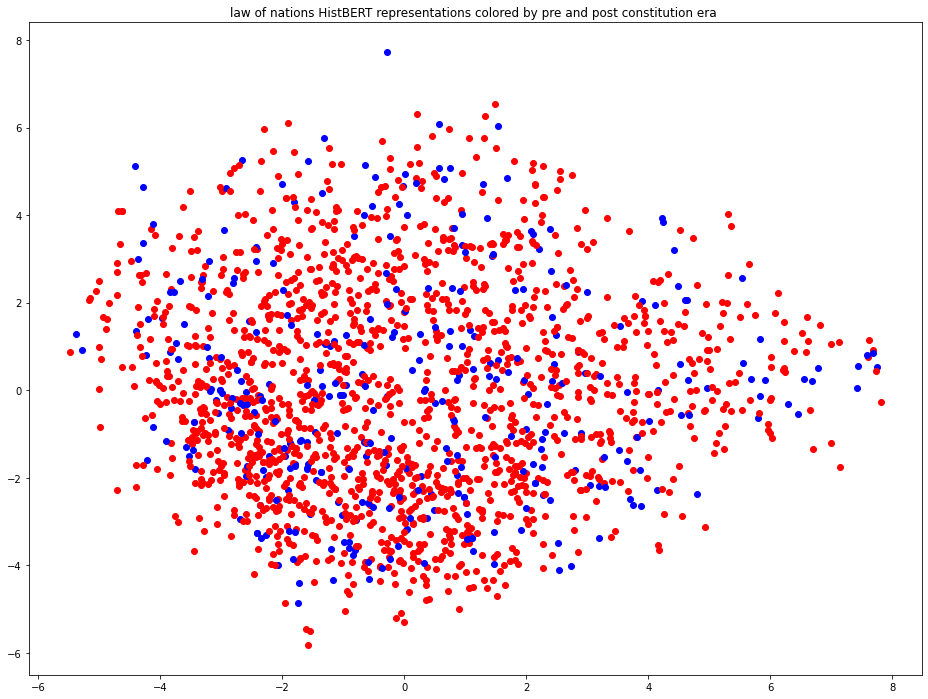

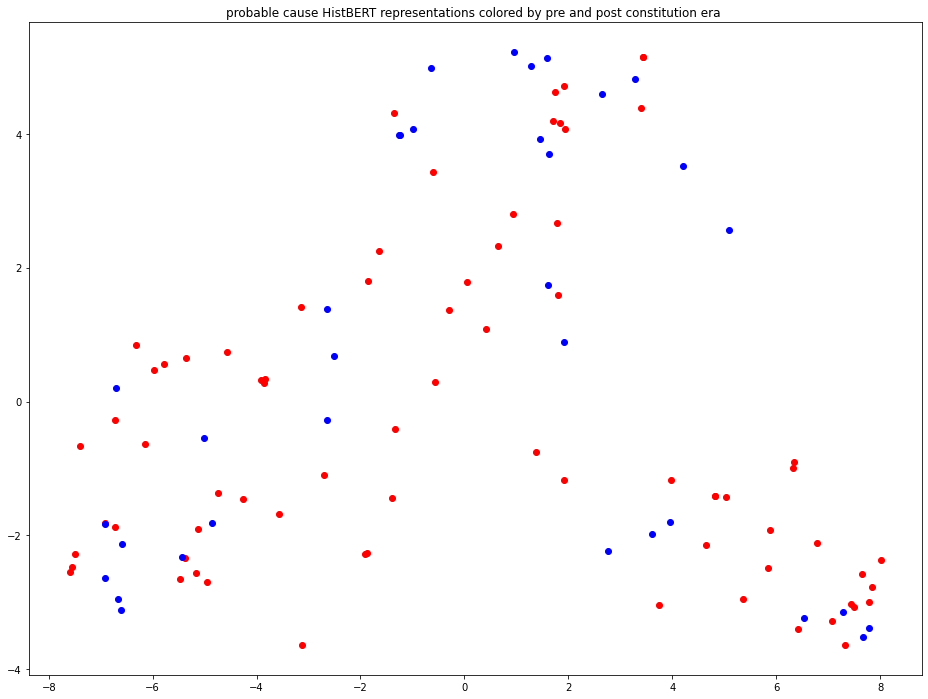

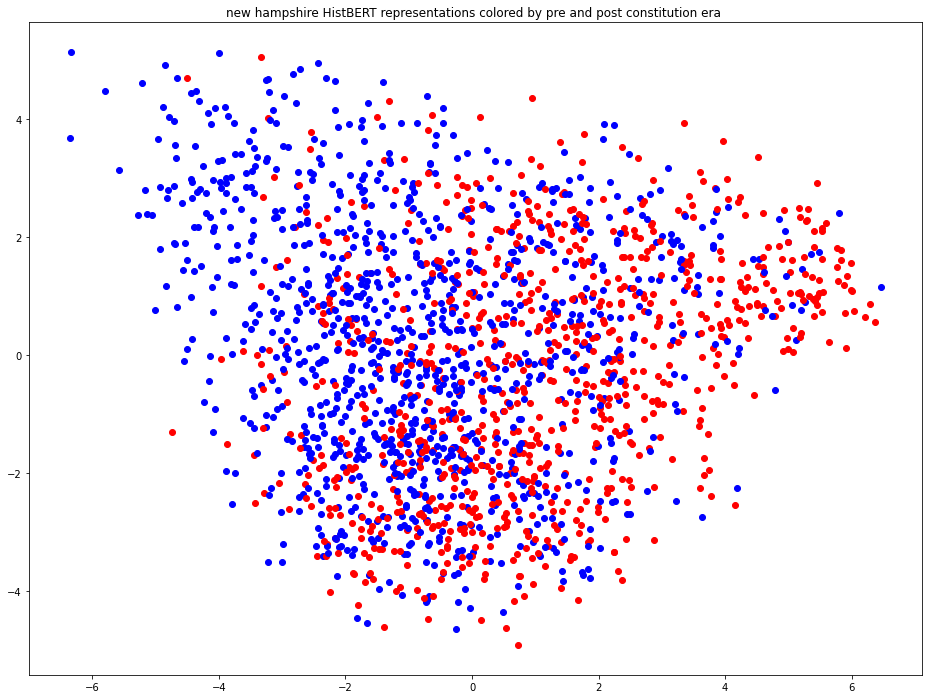

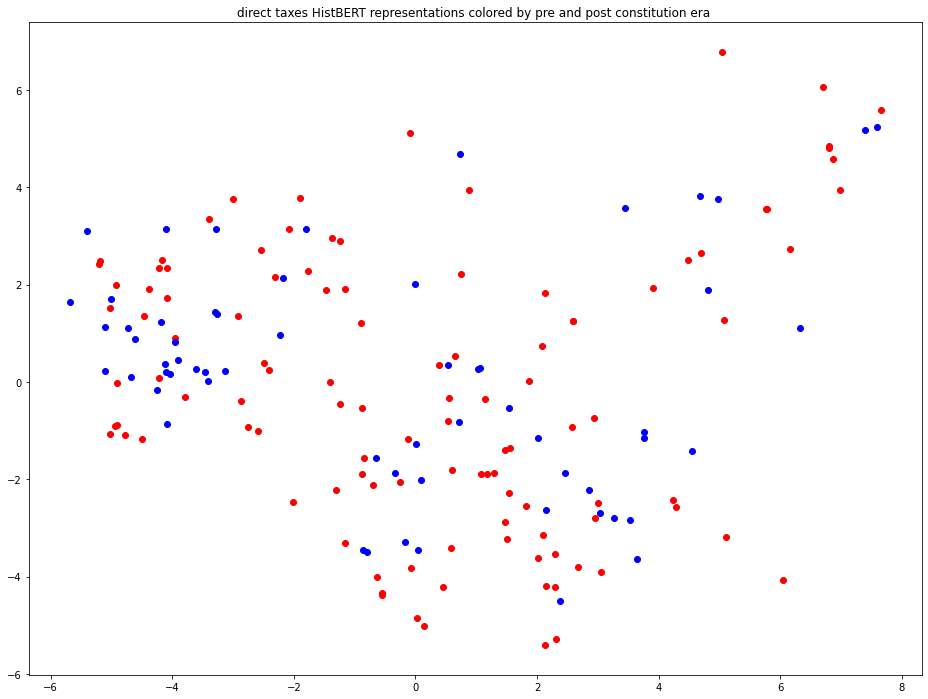

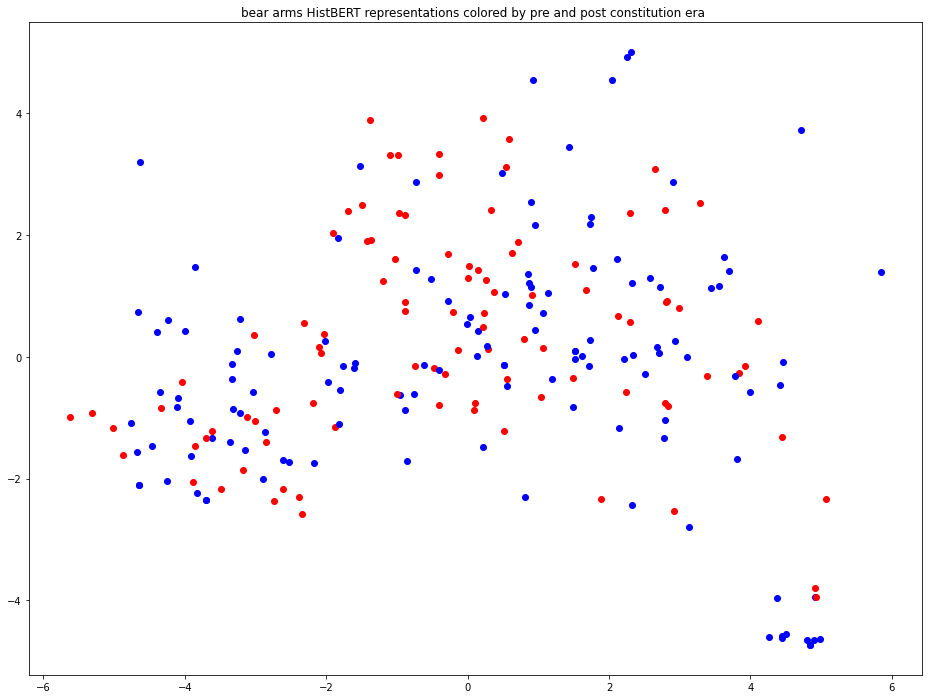

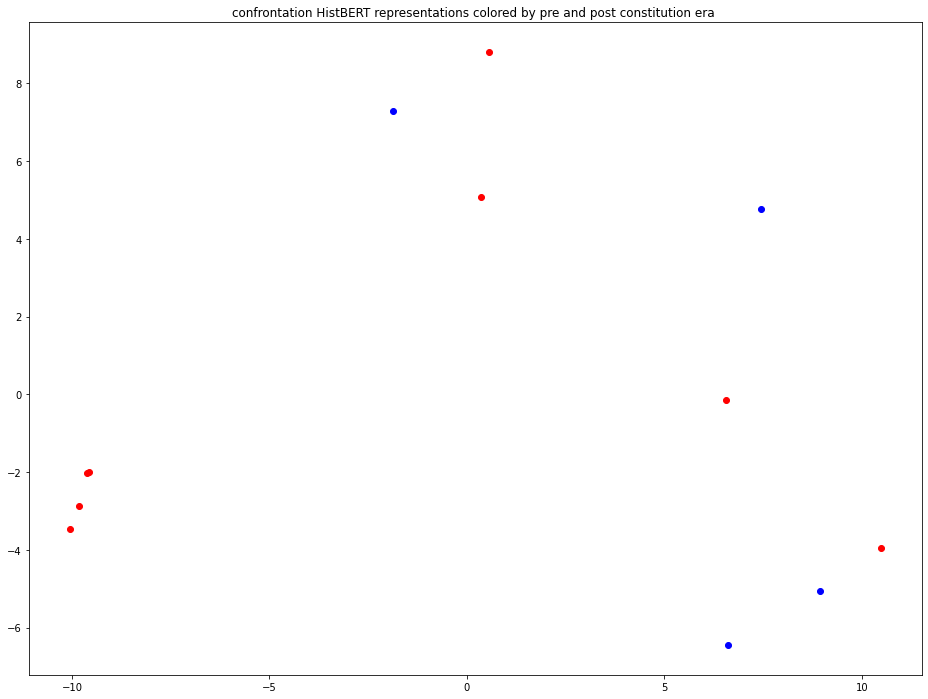

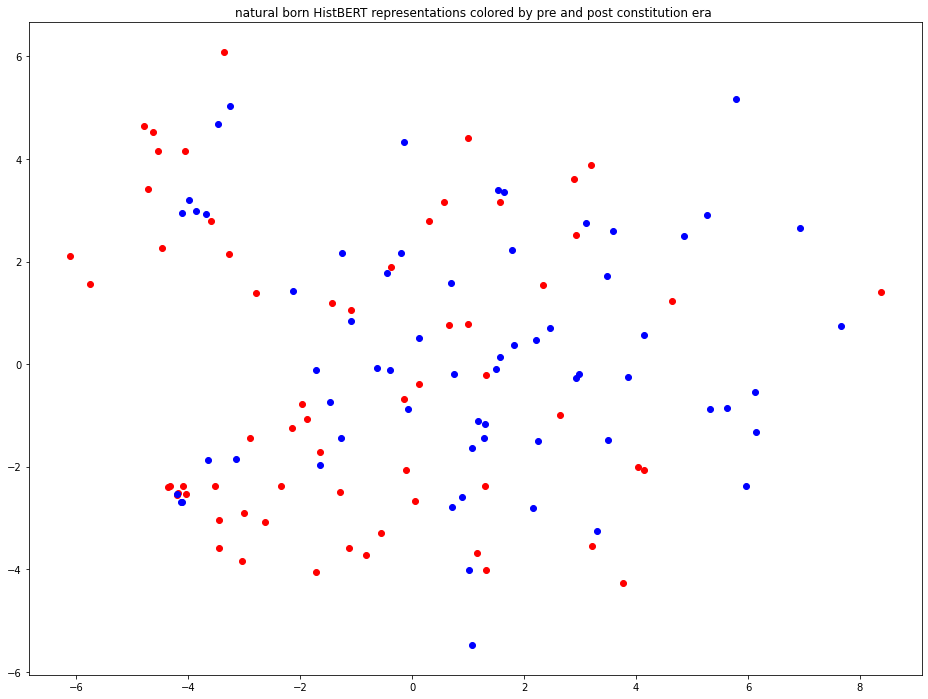

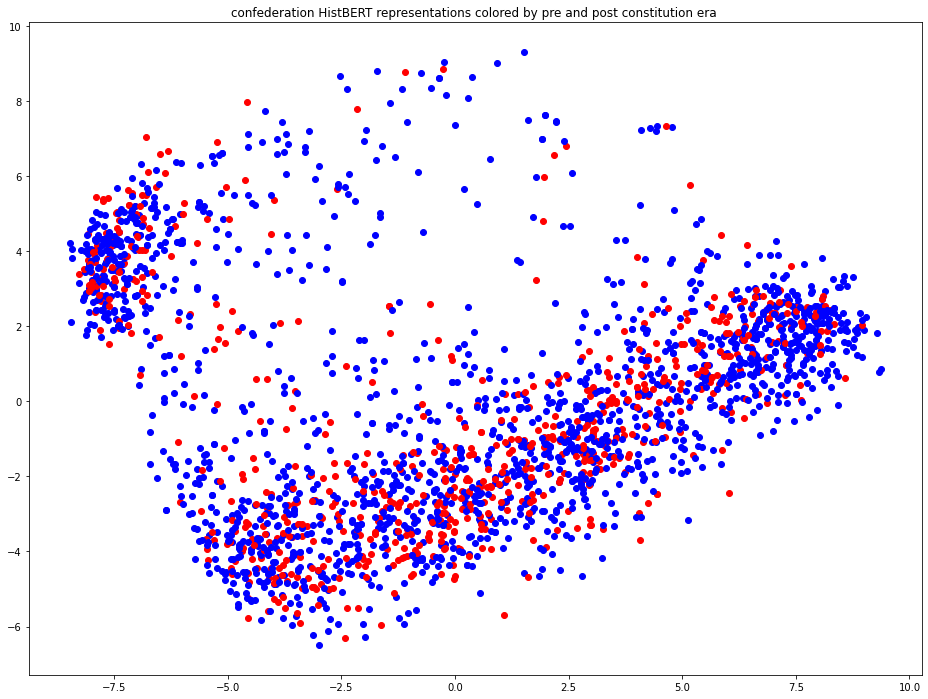

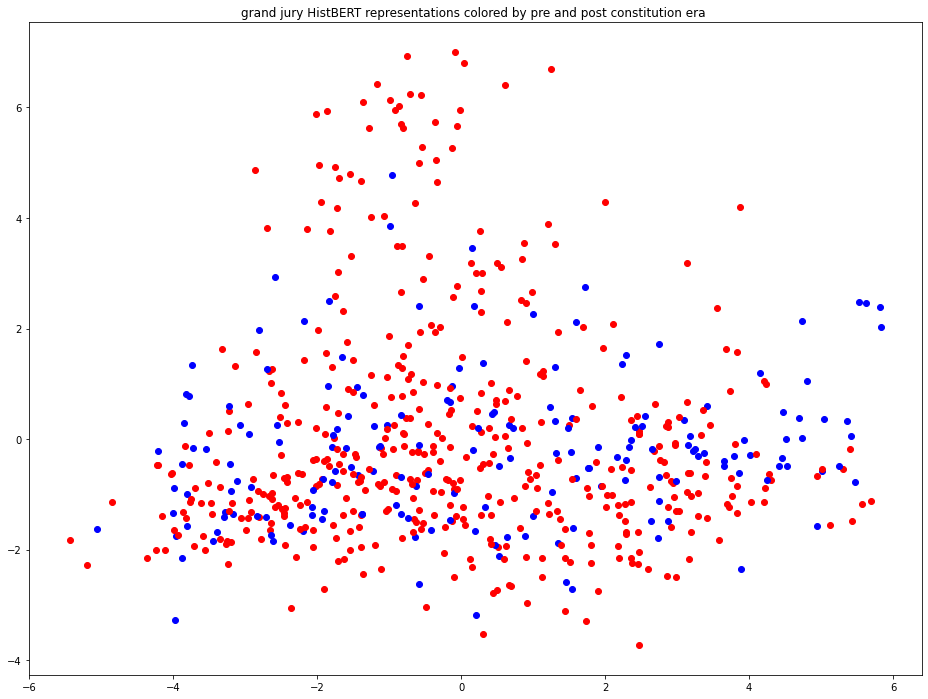

In [52]:
# visualize clustering for lowest scored interest terms visualize the clusters based on time period
graphics_terms = [ term for term,score in 
                 interest_term_kmeans_scores[:10]+interest_term_source_scores[:10]]
for term in tqdm(set(graphics_terms)):
    # get the labels
    date_info = []
    for f_ind,doc_ind,ind in sample_index[term]:
        doc = json.loads(cofea_data[doc_ind])
        if doc['decade'] > 1780:
            date_info.append('post_constitution')
        else:
            date_info.append('pre_constitution')
    # load embeddings
    with open(join(embedding_dir,file_header+term+'.dict'),'rb') as f:
        target_embeddings = pickle.load(f)
    embeddings = target_embeddings[layer]
    pca_viz(embeddings, date_info, term + " HistBERT representations colored by pre and post constitution era "
             ,join(outdir,term+'_histbert_tsne_pre_post_constitution'))

100%|███████████████████████████████████████████| 20/20 [20:51<00:00, 62.59s/it]


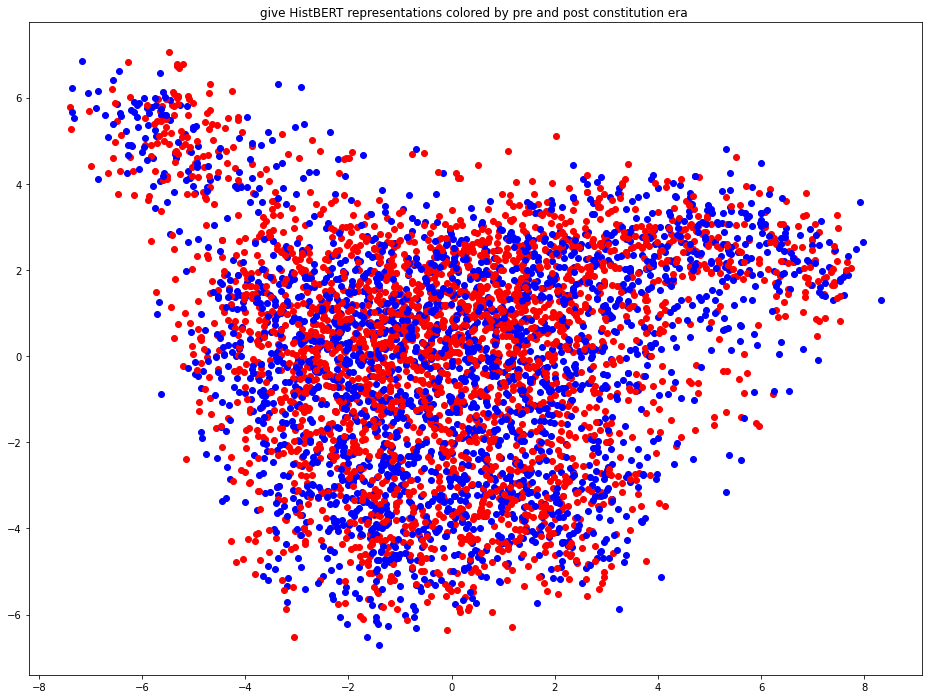

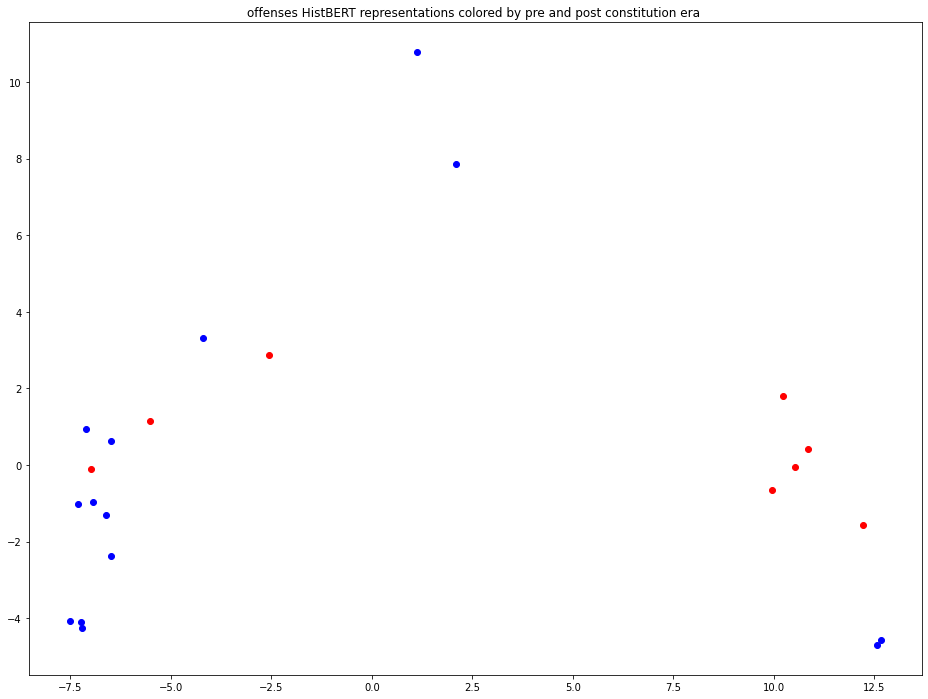

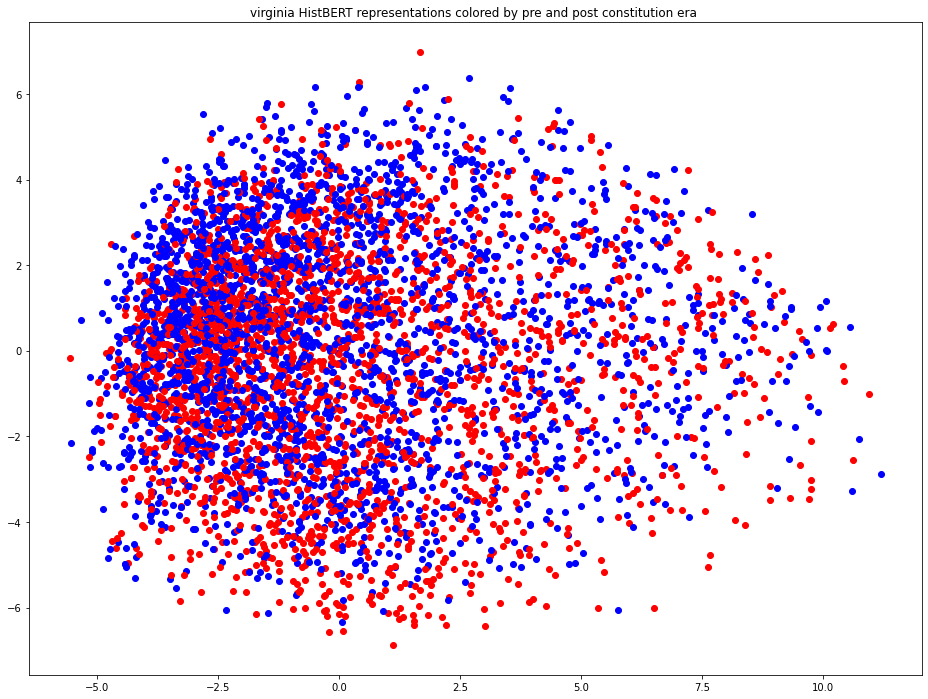

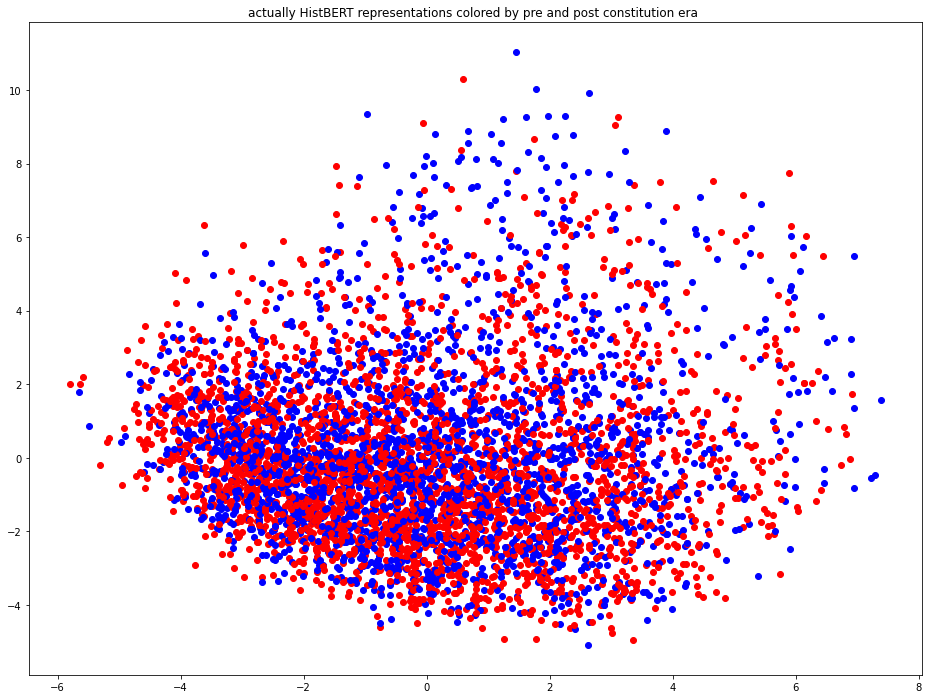

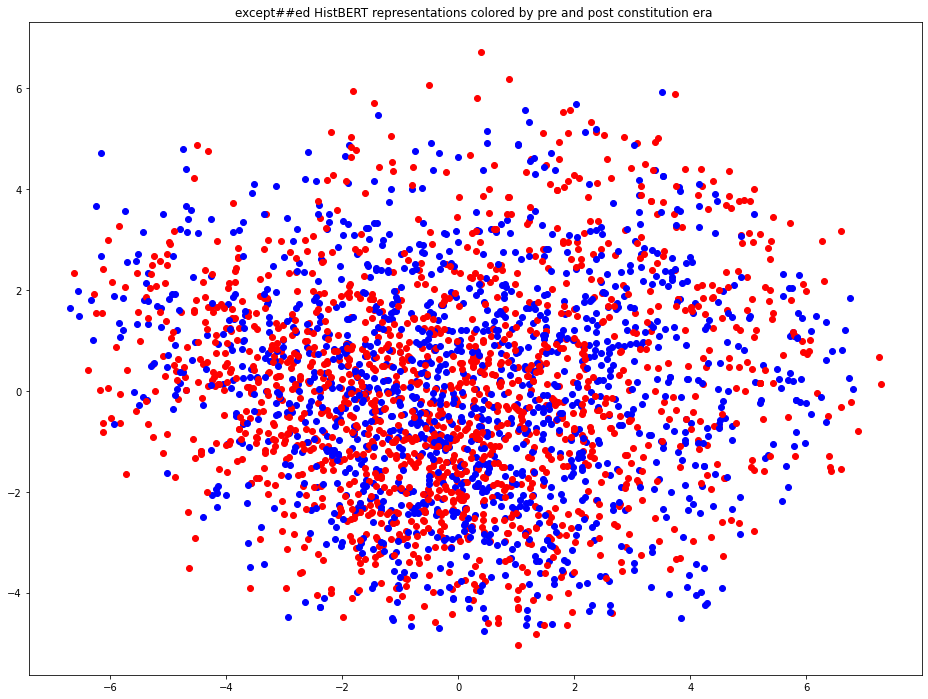

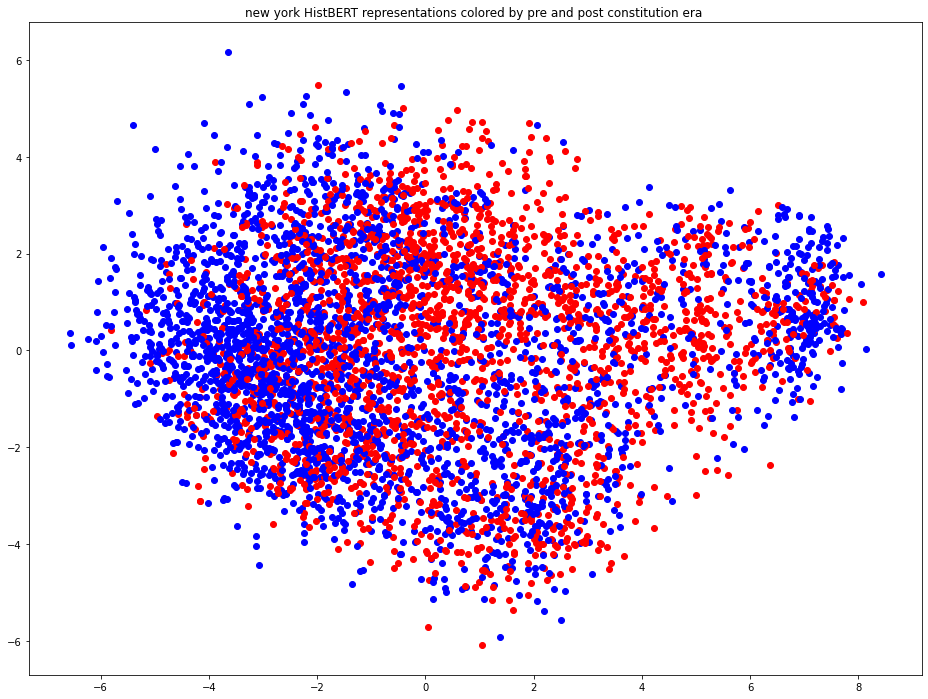

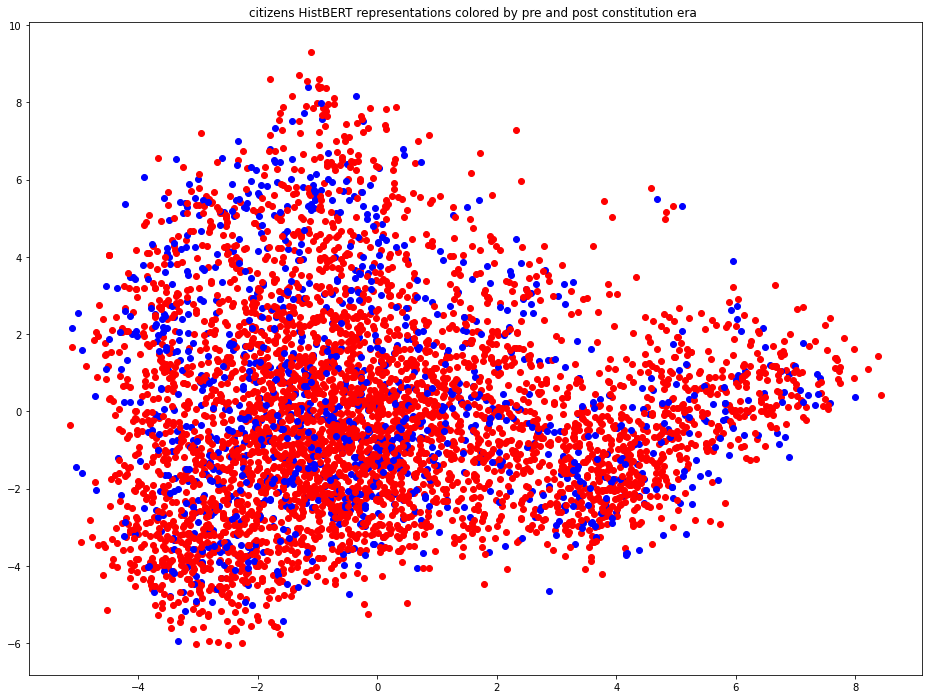

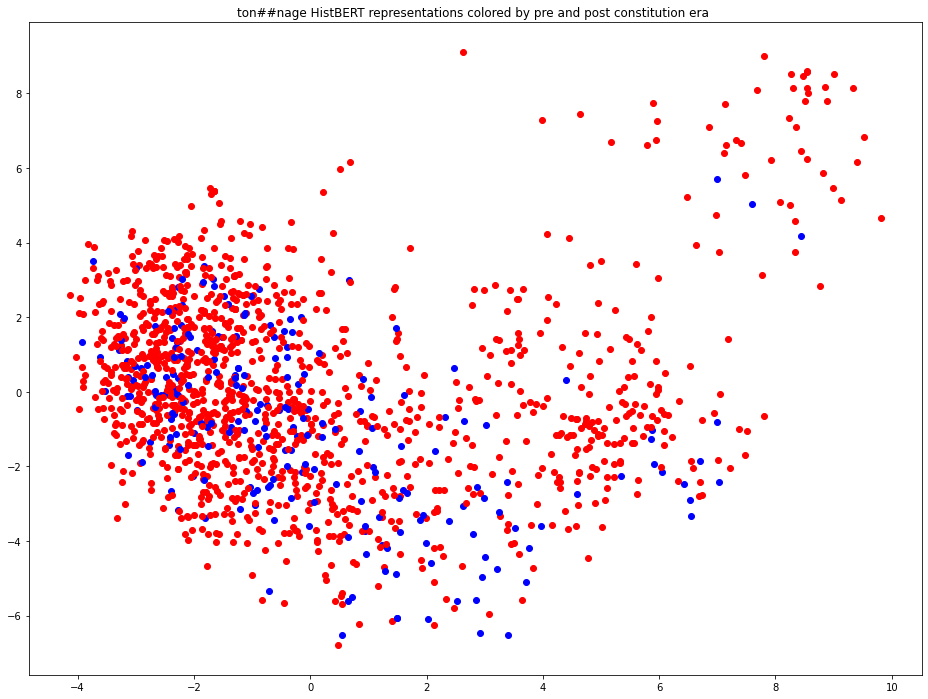

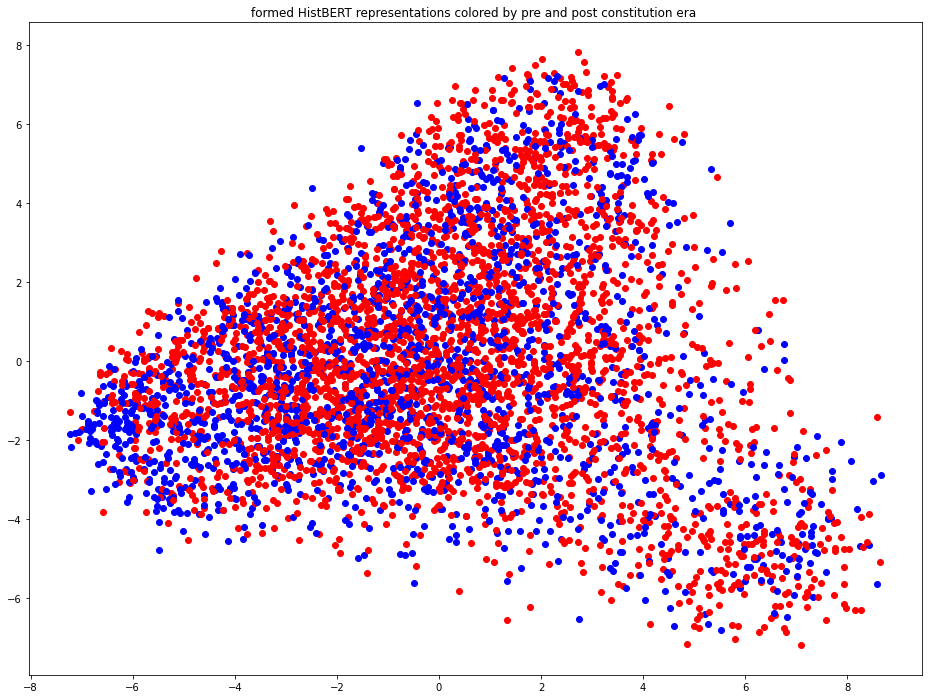

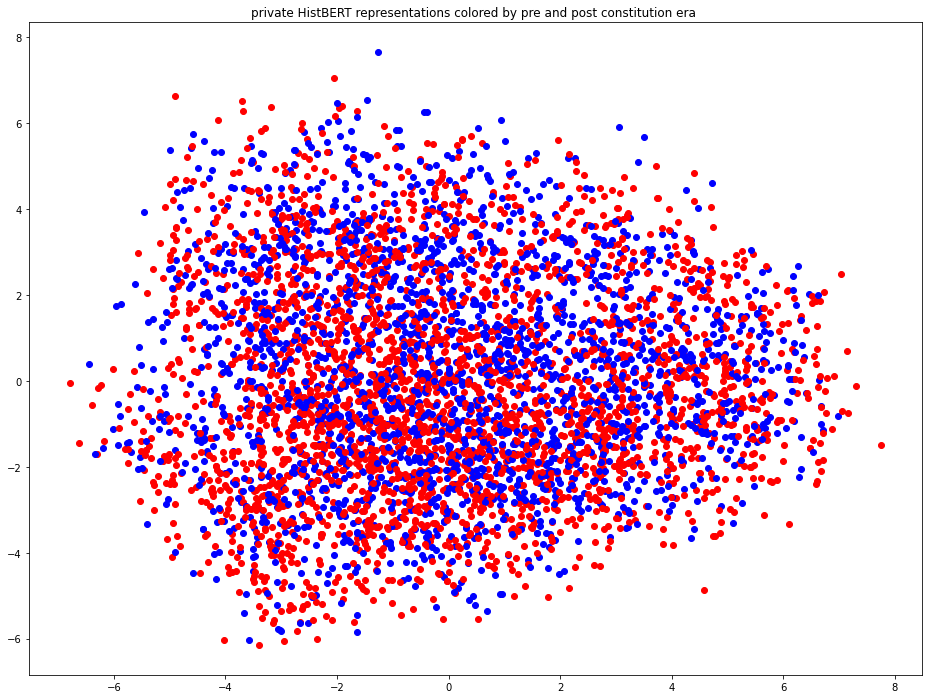

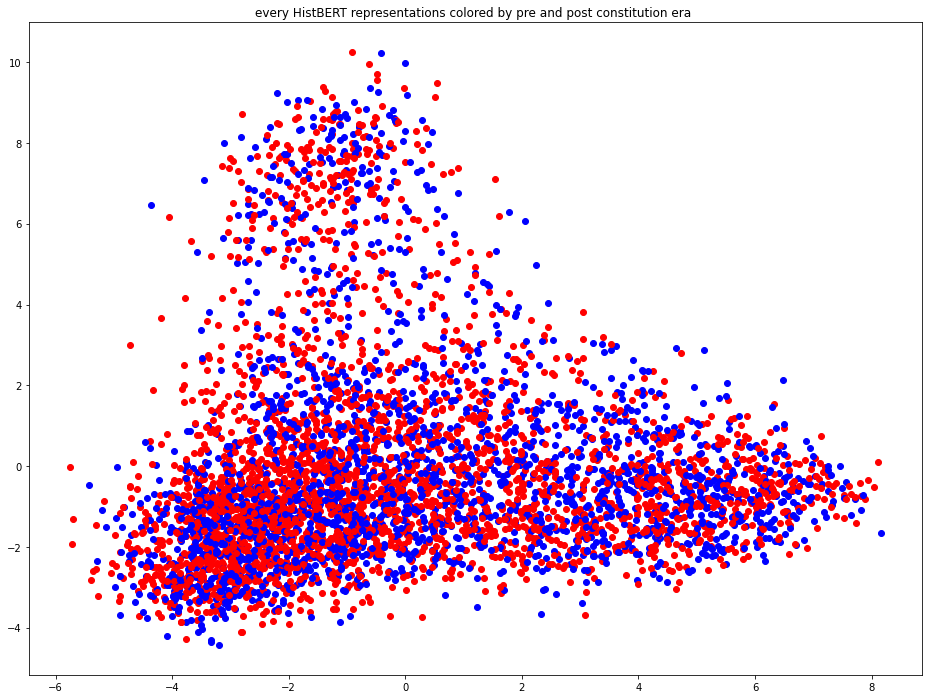

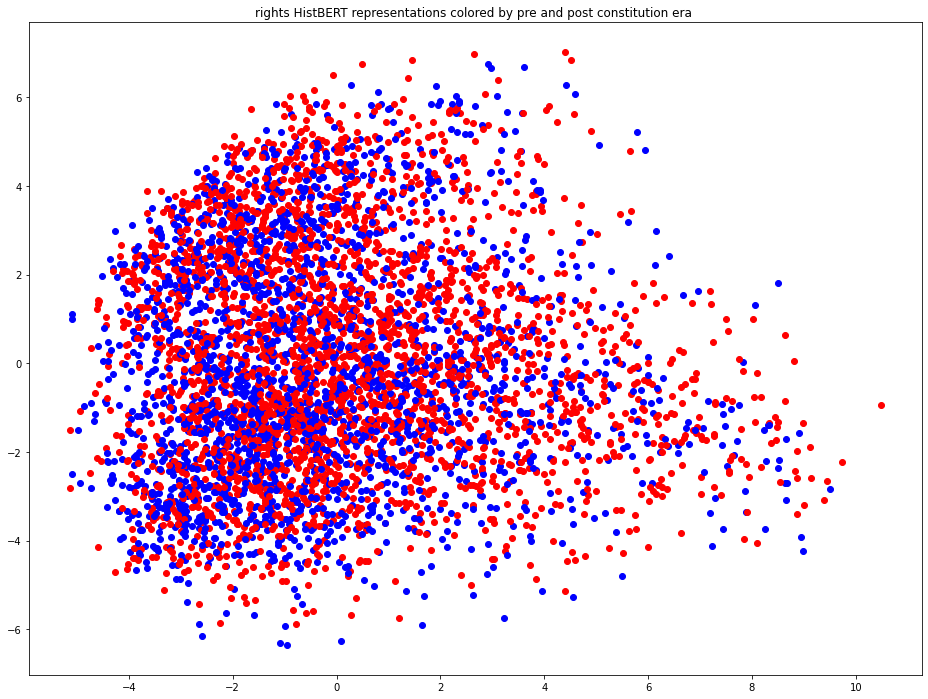

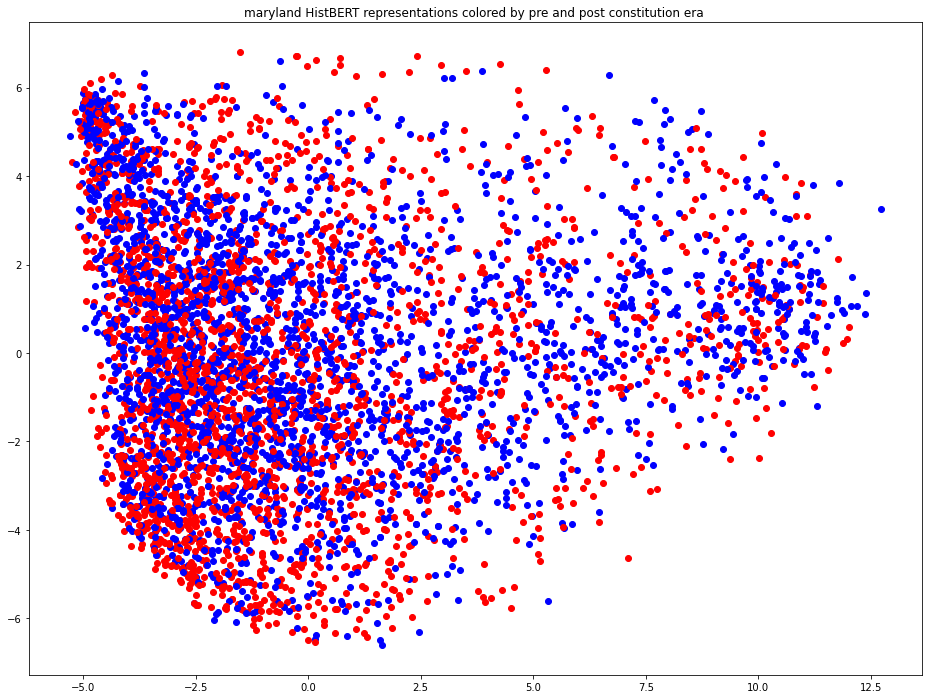

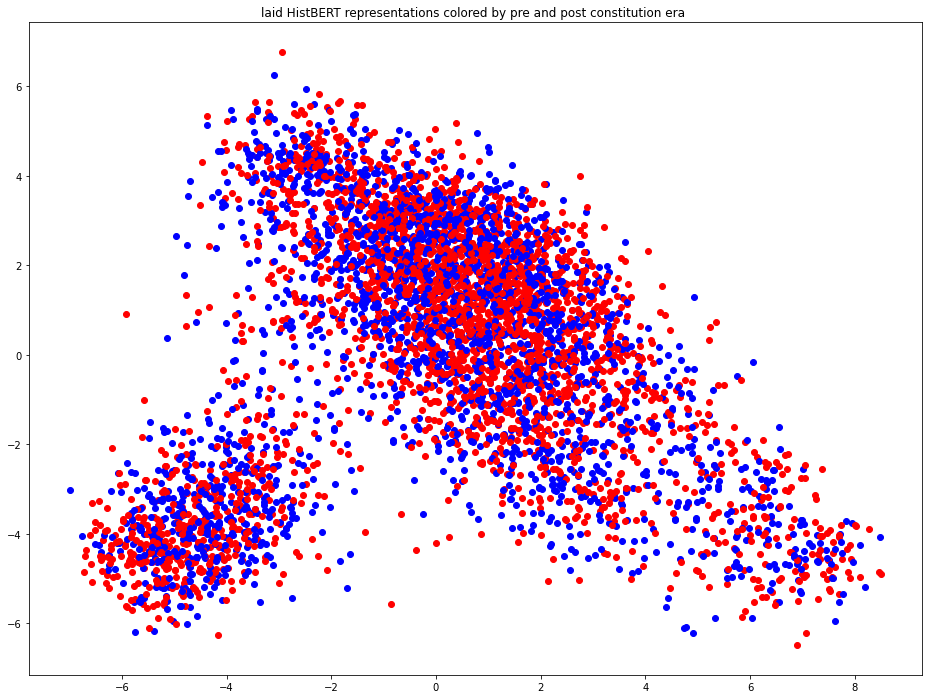

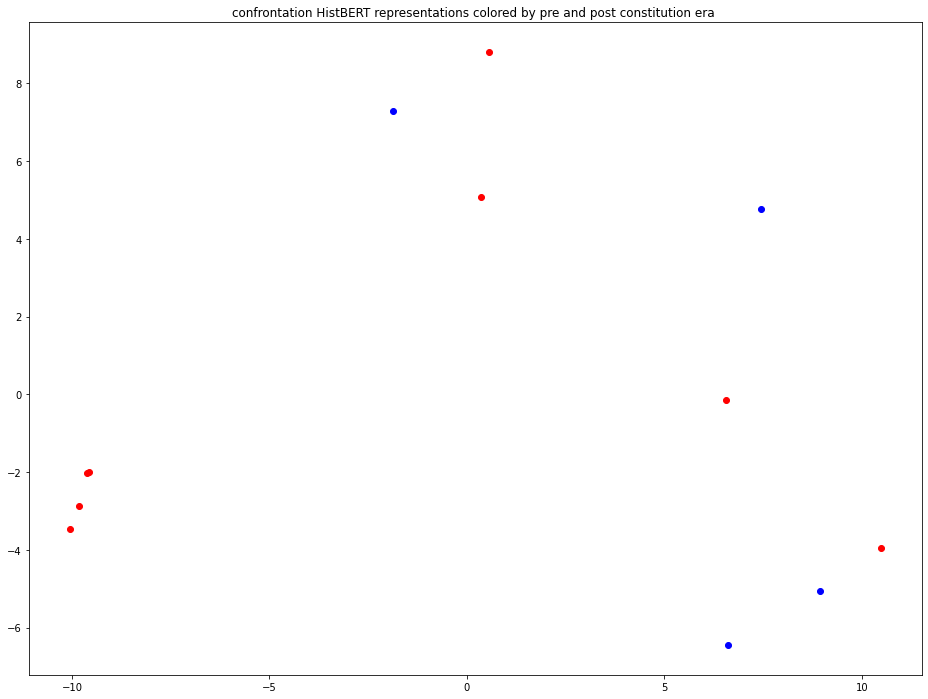

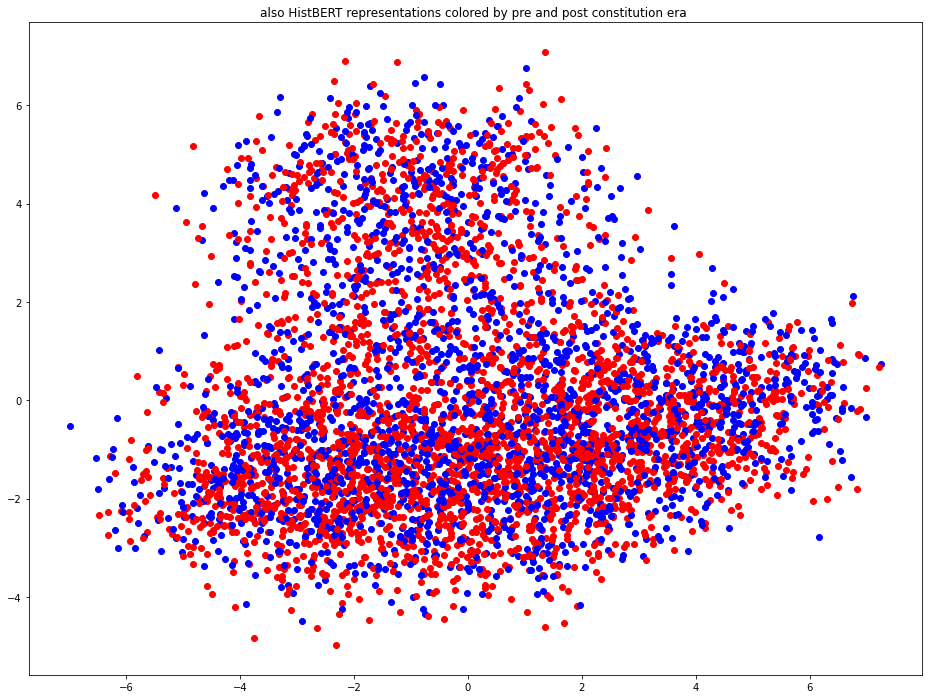

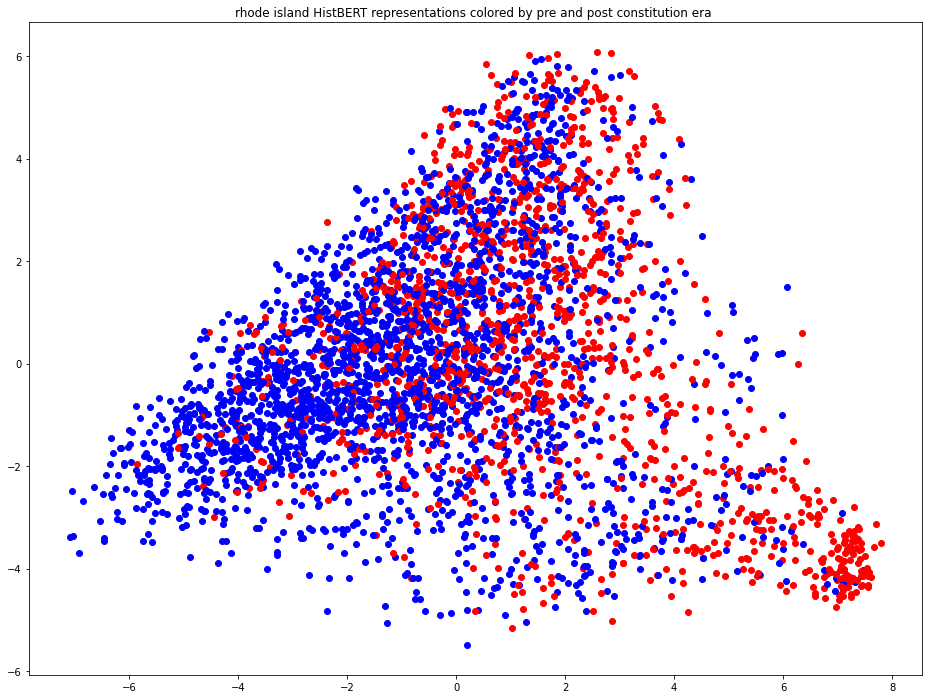

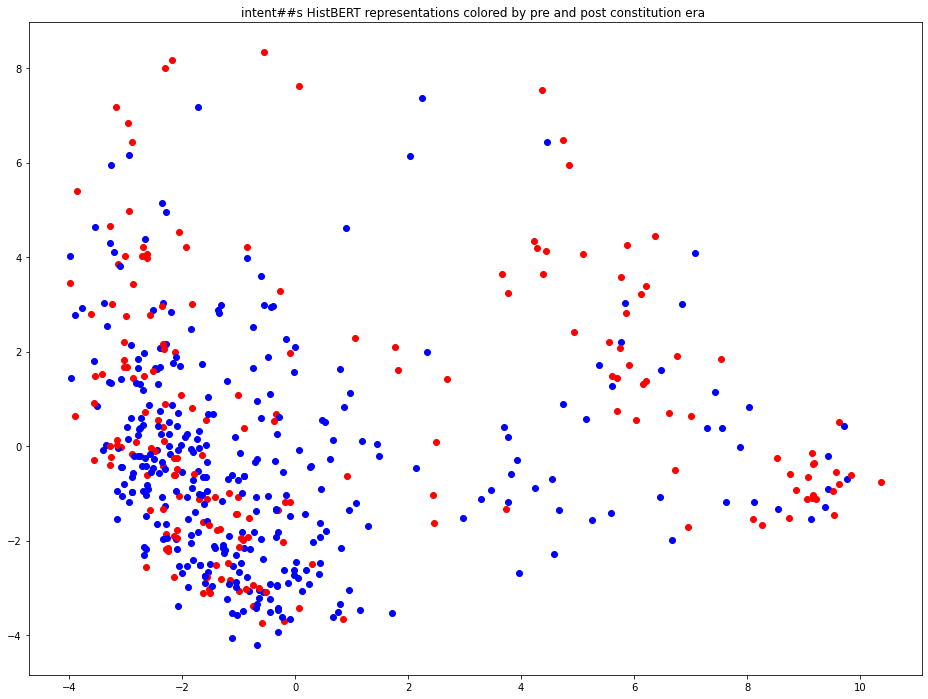

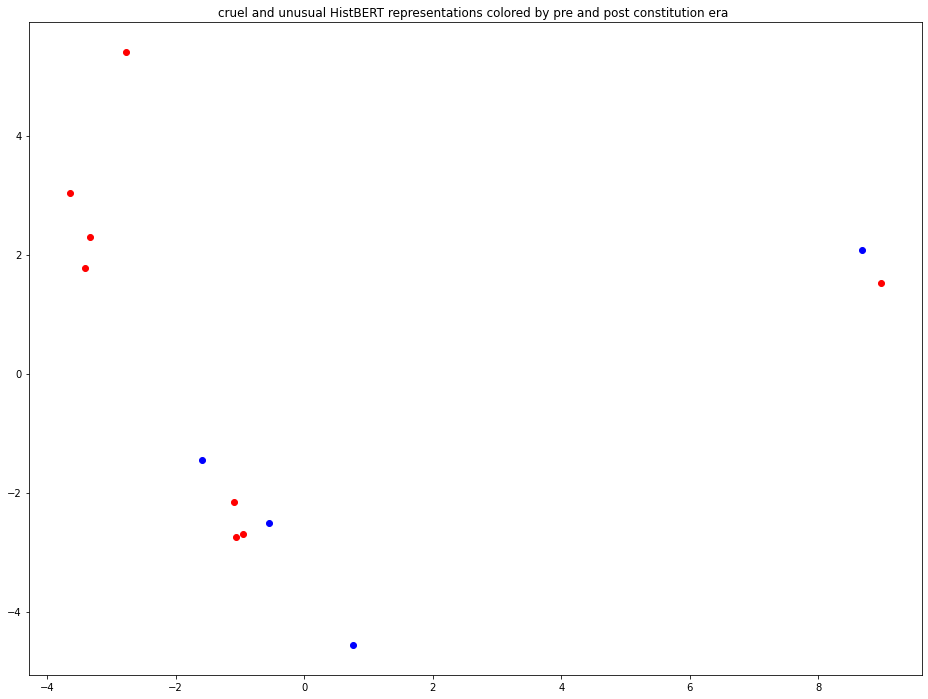

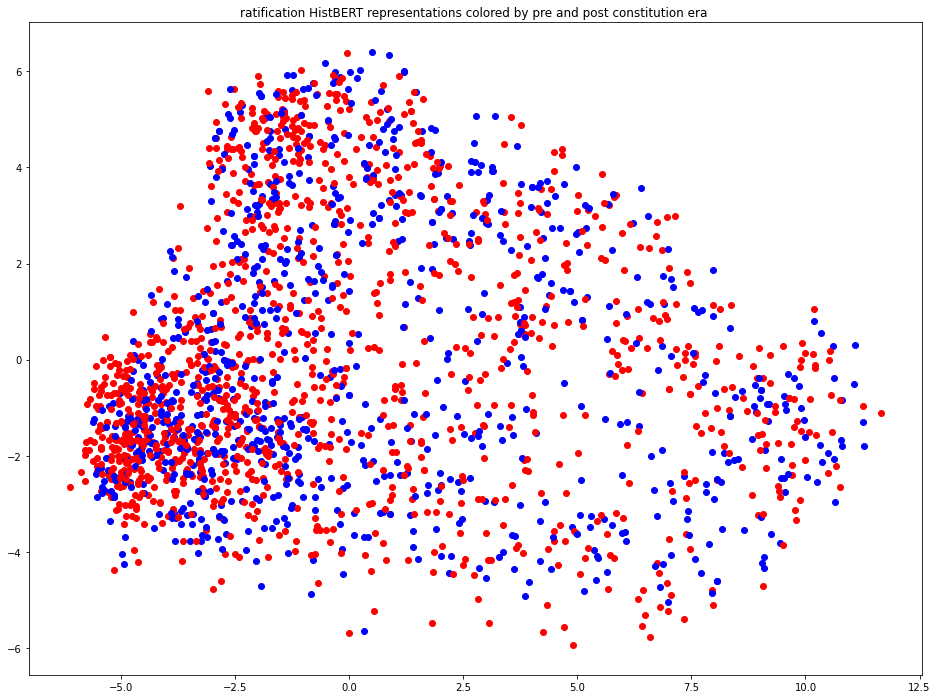

In [55]:
# visualize the clusters based on time period for all terms, lowest scores
graphics_terms = [ term for term,score in kmeans_scores[:10]+source_scores[:10] ]
for term in tqdm(set(graphics_terms)):
    # get the labels
    date_info = []
    for f_ind,doc_ind,ind in sample_index[term]:
        doc = json.loads(cofea_data[doc_ind])
        if doc['decade'] > 1780:
            date_info.append('post_constitution')
        else:
            date_info.append('pre_constitution')
    # load embeddings
    with open(join(embedding_dir,file_header+term+'.dict'),'rb') as f:
        target_embeddings = pickle.load(f)
    embeddings = target_embeddings[layer]
    pca_viz(embeddings, date_info, term + " HistBERT representations colored by pre and post constitution era "
             ,join(outdir,term+'_histbert_tsne_pre_post_constitution'))

## Review the raw scores if needed

In [56]:
# view raw scores
interest_term_kmeans_scores

[('commission', 0.051050786),
 ('new hampshire', 0.05238717),
 ('executive power', 0.055658408),
 ('jury', 0.06263547),
 ('grand jury', 0.0662714),
 ('law of nations', 0.067749284),
 ('bear arms', 0.08178925),
 ('witness', 0.08477599),
 ('natural born', 0.0857445),
 ('executive', 0.08866575),
 ('direct taxes', 0.089715466),
 ('for##feit##ure', 0.092775494),
 ('necessary and proper', 0.093651764),
 ('ce##ssion', 0.094231136),
 ('ex post facto', 0.09548018),
 ('treaty', 0.09555535),
 ('indictment', 0.097414404),
 ('captures', 0.098333836),
 ('bills of credit', 0.098819934),
 ('indian tribes', 0.100434594),
 ('ha##be##as corpus', 0.102668464),
 ('pro tempo##re', 0.105952755),
 ('war', 0.10707664),
 ('im##mun##ities', 0.11228336),
 ('confederation', 0.1212544),
 ('commerce', 0.1250825),
 ('good behavior', 0.12675649),
 ('imminent danger', 0.1272454),
 ('declare war', 0.12983419),
 ('compact', 0.13034631),
 ('treason', 0.13401854),
 ('original jurisdiction', 0.13645157),
 ('controversies', 

In [57]:
interest_term_source_scores

[('cruel and unusual', -0.19026864),
 ('confrontation', -0.102428764),
 ('new hampshire', -0.0030612794),
 ('confederation', -0.0028550795),
 ('commerce', 0.0012016972),
 ('consul##s', 0.0022863129),
 ('treaty', 0.0023344043),
 ('law of nations', 0.00311155),
 ('probable cause', 0.0034873988),
 ('direct taxes', 0.0041546565),
 ('executive', 0.0044563944),
 ('appellate jurisdiction', 0.0045792973),
 ('domestic violence', 0.005788077),
 ('receive ambassadors', 0.0059992503),
 ('captures', 0.0060932375),
 ('alliance', 0.0070786406),
 ('public use', 0.007308382),
 ('compact', 0.007807716),
 ('controversies', 0.007927552),
 ('necessary and proper', 0.009096962),
 ('executive power', 0.00932296),
 ('rep##rie##ves', 0.009430155),
 ('imp##ea##chment', 0.0094958),
 ('bills of credit', 0.009711741),
 ('jury', 0.009778542),
 ('grand jury', 0.010664014),
 ('pro tempo##re', 0.010718961),
 ('ha##be##as corpus', 0.011719429),
 ('for##feit##ure', 0.011739559),
 ('due process', 0.01173992),
 ('im##mun#

In [58]:
kmeans_scores

[('laid', 0.022090778),
 ('citizens', 0.032344937),
 ('private', 0.036172997),
 ('also', 0.0364412),
 ('actually', 0.036939904),
 ('rights', 0.037025005),
 ('give', 0.04024458),
 ('except##ed', 0.041812442),
 ('every', 0.04182804),
 ('formed', 0.042496044),
 ('nothing', 0.043145556),
 ('ins##ure', 0.043310497),
 ('business', 0.043325104),
 ('natural', 0.043943364),
 ('actual', 0.044479247),
 ('officer', 0.044874914),
 ('day', 0.045090474),
 ('citizen', 0.04590816),
 ('increased', 0.046621226),
 ('made', 0.0466888),
 ('app##ort##ioned', 0.046847705),
 ('civil', 0.046951763),
 ('armies', 0.046982218),
 ('forth', 0.04733279),
 ('whose', 0.047656786),
 ('take', 0.047691308),
 ('res##erving', 0.04770669),
 ('upon', 0.047834974),
 ('keep', 0.0479524),
 ('years', 0.048195235),
 ('giving', 0.04827981),
 ('property', 0.04866843),
 ('without', 0.048845824),
 ('good', 0.04885409),
 ('prosecution##s', 0.050414514),
 ('laws', 0.050635442),
 ('commission', 0.051050786),
 ('drawn', 0.051461432),
 ('e

In [59]:
source_scores

[('cruel and unusual', -0.19026864),
 ('confrontation', -0.102428764),
 ('offenses', -0.026090963),
 ('rhode island', -0.014547212),
 ('maryland', -0.012713616),
 ('ton##nage', -0.011055579),
 ('new york', -0.010448977),
 ('ratification', -0.009190354),
 ('intent##s', -0.0082669575),
 ('virginia', -0.0056088953),
 ('carolina', -0.0052145054),
 ('expenditures', -0.004352986),
 ('ports', -0.0042210906),
 ('whatsoever', -0.0040254677),
 ('arsenal##s', -0.003417707),
 ('compensation', -0.003396514),
 ('new hampshire', -0.0030612794),
 ('confederation', -0.0028550795),
 ('em##ol##umen##ts', -0.0028334653),
 ('admiralty', -0.00070876203),
 ('south carolina', -0.0007046428),
 ('appropriations', -0.00053605845),
 ('dollars', 0.00037204413),
 ('debts', 0.0004205326),
 ('guarantee', 0.00069655123),
 ('corpus', 0.0008816748),
 ('commerce', 0.0012016972),
 ('counter##feit##ing', 0.0013072084),
 ('organizing', 0.0014304306),
 ('conventions', 0.0015329693),
 ('revision', 0.0015904714),
 ('maritime',